In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.losses import mean_squared_error as mse

from tensorflow.linalg import expm,logm

/home/teguh/.local/lib/python2.7/site-packages/pandas/_libs/__init__.py:4: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .tslib import iNaT, NaT, Timestamp, Timedelta, OutOfBoundsDatetime
/home/teguh/.local/lib/python2.7/site-packages/pandas/__init__.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import (hashtable as _hashtable,
/home/teguh/.local/lib/python2.7/site-packages/pandas/core/dtypes/common.py:6: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import algos, lib
/home/teguh/.local/lib/python2.7/site-packages/pandas/core/util/hashing.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from pandas._libs import hashing, tslib
/home/teguh/.local/lib/python2.7/site-packages/pandas/core/indexes/base.py:7: RuntimeWarning: n

In [2]:
from numpy.random import multivariate_normal as mvn


In [3]:
sess = tf.InteractiveSession()

### Load Data 

In [4]:
from scipy.io import loadmat
data_train = loadmat('data/sarcos_inv.mat')
data_test = loadmat('data/sarcos_inv_test.mat')

x_train = data_train['sarcos_inv'][:,:21]
y_train = data_train['sarcos_inv'][:,21:22]
y_var = np.var(y_train)

x_test = data_test['sarcos_inv_test'][:,:21]
y_test = data_test['sarcos_inv_test'][:,21:22]

### Standard Linear Regression

In [5]:
X  = np.hstack([np.ones((x_train.shape[0],1)), x_train])
Y = y_train.copy()
lamda = 0.00001
w = np.dot(np.dot(np.linalg.inv(np.dot(X.T,X)+lamda*np.eye(X.shape[1])),X.T),Y)

y_pred = np.dot(np.hstack([np.ones((x_train.shape[0],1)), x_train]), w)
smse_train = (mean_squared_error(y_pred,y_train))/y_var
y_pred = np.dot(np.hstack([np.ones((x_test.shape[0],1)), x_test]), w)
smse_test = (mean_squared_error(y_pred,y_test))/y_var

print smse_train,smse_test

0.07358881422797761 0.0742260930366048


In [6]:
w_standard = w.copy()

### Bayesian Linear Regression 

### Generate simple dataset 

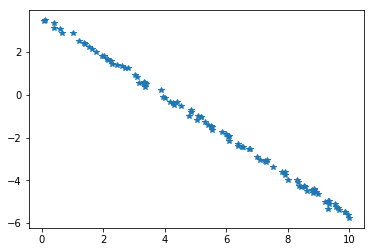

In [104]:
N=100
X = np.hstack([np.ones((N,1)), 10*np.random.rand(N,1)])#, 3*np.random.rand(N,1), 2*np.random.rand(N,1), \
#           3*np.random.rand(N,1), 3*np.random.rand(N,1), 2*np.random.rand(N,1), \
#              3*np.random.rand(N,1), 3*np.random.rand(N,1), 2*np.random.rand(N,1), \
#              3*np.random.rand(N,1), 3*np.random.rand(N,1), 2*np.random.rand(N,1), \
#              3*np.random.rand(N,1), 3*np.random.rand(N,1), 2*np.random.rand(N,1)])#,
#             3*np.random.rand(N,1), 3*np.random.rand(N,1), 2*np.random.rand(N,1),
#              3*np.random.rand(N,1), 3*np.random.rand(N,1), 2*np.random.rand(N,1)]) 
D = X.shape[1]
w_true = 3*np.random.normal(size=[D,1])
Y = np.dot(X,w_true) + 0.1*np.random.normal(size=[N,1])
plt.plot(X[:,1],Y,'*')

In [13]:
from math import e

In [14]:
def posterior(theta, params, X, Y):
    alpha = params[0]
    w = theta[:-1]
    #lamda = params[1]
    lamda = tf.square(theta[-1])
    n = X.shape[0]
    d = X.shape[1]-1
    val = (n+1)*tf.log(2*np.pi) - n*d*tf.log(lamda) + tf.log(alpha) + 0.5*(tf.matmul(tf.transpose(w),w))
    val += (0.5*tf.matmul(tf.transpose(Y-tf.matmul(X,w)), Y-tf.matmul(X,w))*lamda)
    return val

In [15]:
def ELBO(mu,L,samples, params, X, Y):
    d = int(samples.shape[1])
    n = int(samples.shape[0])
    val = 0.5*d*(tf.log(2*np.pi)+1) + tf.trace(L)
    L_sym = 0.5*(L+tf.transpose(L))
    for i in range(samples.shape[0]):
        val -= posterior(mu + tf.matmul(expm(L_sym),tf.transpose(samples[i:i+1])), params, X, Y)/n
    return val

In [108]:
alpha = 10000.
#lamda = 10.
params = [alpha]#,lamda]
D_in = X.shape[1]+1
D_out = 1
batch_size = 50
mu_0 = np.random.rand(D_in,1).astype(np.float32)
L_0 = np.eye(D_in).astype(np.float32)

mu = tf.Variable(mu_0.copy())
L = tf.Variable(L_0.copy())

X = X.astype(np.float32)
Y = Y.astype(np.float32)

error_mse = mse(tf.matmul(X,mu[:-1]),Y)
post = posterior(mu,params,X,Y)

samples = tf.placeholder(tf.float32,shape=(batch_size, D_in))

In [109]:
elbo = ELBO(mu,L,samples, params, X, Y)

In [110]:
optimizer = tf.train.AdamOptimizer(0.1)
train = optimizer.minimize(-elbo,var_list=[mu,L])

sess.run(tf.global_variables_initializer())

In [111]:
for i in range(5000):
    cur_samples = np.array([np.random.normal(np.zeros(D_in)) for j in range(batch_size)])
    _,val,elbo_,mu_,e_ = sess.run([train,post, elbo,mu,error_mse],feed_dict={samples:cur_samples})
    print i,val,elbo_,e_

0 [[1186.3617]] [[-138049.38]] 47.045357
1 [[835.9695]] [[-220758.47]] 38.11758
2 [[696.6587]] [[-52555.824]] 36.7887
3 [[599.18445]] [[-93176.3]] 33.52893
4 [[563.0409]] [[-18614.676]] 29.013704
5 [[571.85046]] [[-26667.908]] 24.470484
6 [[613.6427]] [[-18626.842]] 20.777285
7 [[695.17505]] [[-24705.37]] 17.22603
8 [[876.97546]] [[-12874.042]] 13.765608
9 [[1016.7039]] [[-11375.892]] 10.809583
10 [[743.57513]] [[-4636.069]] 8.272401
11 [[640.1806]] [[-5340.818]] 6.35978
12 [[578.0948]] [[-5104.9126]] 4.975391
13 [[537.3052]] [[-6329.3564]] 4.019453
14 [[505.44434]] [[-2152.0352]] 3.341814
15 [[480.89447]] [[-2266.1755]] 2.9311056
16 [[461.65228]] [[-4455.002]] 2.7110639
17 [[448.05463]] [[-2392.7695]] 2.6391408
18 [[438.12128]] [[-2764.7976]] 2.6641767
19 [[432.06586]] [[-1306.2946]] 2.781004
20 [[427.984]] [[-1222.2113]] 2.9615471
21 [[425.17102]] [[-2215.3252]] 3.1844566
22 [[423.2602]] [[-3630.0195]] 3.4166393
23 [[422.66003]] [[-1942.9489]] 3.6085305
24 [[422.7217]] [[-1770.6548]]

218 [[372.21652]] [[-994.9313]] 1.2060164
219 [[369.93594]] [[-618.1434]] 1.1967441
220 [[366.5082]] [[-740.7242]] 1.1890075
221 [[363.93893]] [[-626.97833]] 1.1817676
222 [[362.0683]] [[-918.63983]] 1.1742307
223 [[361.17798]] [[-735.30225]] 1.1634222
224 [[360.79254]] [[-902.6963]] 1.1533861
225 [[360.50018]] [[-751.61945]] 1.1463779
226 [[360.59888]] [[-791.1545]] 1.1429086
227 [[359.91516]] [[-722.4261]] 1.1435821
228 [[359.72736]] [[-1117.9592]] 1.1451629
229 [[360.67648]] [[-756.8688]] 1.1525956
230 [[362.06705]] [[-736.98755]] 1.1487948
231 [[363.59766]] [[-863.99115]] 1.1379905
232 [[396.62048]] [[-568.91907]] 1.1269119
233 [[434.32294]] [[-539.76495]] 1.1115823
234 [[478.13278]] [[-550.0734]] 1.0990548
235 [[529.866]] [[-612.21484]] 1.0868856
236 [[592.449]] [[-800.38275]] 1.0764849
237 [[675.6789]] [[-699.46936]] 1.0680825
238 [[785.20734]] [[-511.78586]] 1.0586975
239 [[990.88885]] [[-989.5849]] 1.0507762
240 [[1041.132]] [[-650.5476]] 1.043787
241 [[815.50854]] [[-510.1661]

416 [[221.081]] [[-532.2749]] 0.14721787
417 [[222.29875]] [[-571.3813]] 0.1487006
418 [[223.56325]] [[-553.4393]] 0.14969647
419 [[225.13286]] [[-469.48828]] 0.1568996
420 [[226.23564]] [[-480.80038]] 0.1583109
421 [[227.41829]] [[-394.13794]] 0.16475008
422 [[228.30766]] [[-474.6637]] 0.16904606
423 [[228.89526]] [[-437.11584]] 0.16699812
424 [[229.36247]] [[-507.1394]] 0.16419834
425 [[229.25537]] [[-454.76678]] 0.15688796
426 [[229.1889]] [[-543.37225]] 0.14914076
427 [[229.18976]] [[-577.3441]] 0.14214566
428 [[229.20483]] [[-579.6908]] 0.13475294
429 [[229.42647]] [[-448.0691]] 0.13156869
430 [[229.9953]] [[-498.46655]] 0.12731132
431 [[229.95901]] [[-513.9973]] 0.12636411
432 [[229.93532]] [[-563.11633]] 0.12423671
433 [[229.89725]] [[-448.69522]] 0.11810813
434 [[230.01411]] [[-499.74747]] 0.11496003
435 [[230.26521]] [[-493.7925]] 0.112698376
436 [[230.60933]] [[-636.8089]] 0.11185254
437 [[231.20563]] [[-451.4182]] 0.11233145
438 [[231.81693]] [[-525.398]] 0.112359196
439 [[2

611 [[240.99297]] [[-367.75784]] 0.028212326
612 [[241.43962]] [[-426.39648]] 0.027886841
613 [[241.88712]] [[-368.0501]] 0.026911452
614 [[242.19064]] [[-341.70218]] 0.026296172
615 [[242.37314]] [[-368.20972]] 0.025966551
616 [[242.52394]] [[-375.50467]] 0.02591029
617 [[242.70203]] [[-428.89532]] 0.0261196
618 [[242.84831]] [[-331.85126]] 0.027193017
619 [[242.87239]] [[-360.42688]] 0.028196838
620 [[242.88568]] [[-440.22043]] 0.029906522
621 [[242.83463]] [[-361.34555]] 0.03013412
622 [[242.7433]] [[-375.75812]] 0.030982442
623 [[242.47034]] [[-423.5374]] 0.030316005
624 [[242.14336]] [[-372.3938]] 0.028943837
625 [[241.98444]] [[-365.49744]] 0.028013
626 [[241.60176]] [[-339.36703]] 0.026609156
627 [[241.15932]] [[-400.0761]] 0.025593245
628 [[240.99301]] [[-381.1526]] 0.024810158
629 [[240.81725]] [[-372.23]] 0.024869032
630 [[240.66975]] [[-357.46863]] 0.025308149
631 [[240.3982]] [[-412.59222]] 0.02535736
632 [[239.97943]] [[-408.1066]] 0.02453197
633 [[239.65344]] [[-444.5763]

801 [[188.84583]] [[-318.25513]] 0.047397364
802 [[188.38567]] [[-307.059]] 0.045389876
803 [[187.88507]] [[-270.13336]] 0.04230256
804 [[187.72775]] [[-337.81152]] 0.04589509
805 [[187.3232]] [[-290.61673]] 0.048981905
806 [[186.82378]] [[-387.94543]] 0.04995171
807 [[185.7595]] [[-298.80798]] 0.040135253
808 [[184.42941]] [[-330.12543]] 0.026109518
809 [[183.68318]] [[-336.32132]] 0.021549514
810 [[182.929]] [[-360.52115]] 0.0154306935
811 [[182.35587]] [[-284.46674]] 0.012909639
812 [[182.01234]] [[-328.02054]] 0.014265431
813 [[181.86476]] [[-294.7561]] 0.017853908
814 [[181.70168]] [[-256.84616]] 0.020964373
815 [[181.54889]] [[-298.10138]] 0.024290431
816 [[181.32668]] [[-292.25558]] 0.026292197
817 [[180.9517]] [[-343.63098]] 0.025922239
818 [[180.58644]] [[-265.42807]] 0.025111778
819 [[180.24983]] [[-290.3462]] 0.025192523
820 [[180.11536]] [[-279.07474]] 0.0268897
821 [[179.95892]] [[-294.5336]] 0.028487759
822 [[179.5389]] [[-289.80066]] 0.02561506
823 [[179.30191]] [[-342.5

988 [[140.37592]] [[-231.15804]] 0.011535753
989 [[140.11948]] [[-257.75983]] 0.010703978
990 [[140.004]] [[-240.9759]] 0.011168293
991 [[139.82039]] [[-241.1113]] 0.0110121695
992 [[139.5916]] [[-226.73883]] 0.010683617
993 [[139.50906]] [[-217.89325]] 0.012014053
994 [[139.5055]] [[-271.46512]] 0.014103645
995 [[139.75719]] [[-273.27817]] 0.018755704
996 [[139.61662]] [[-229.18335]] 0.018745318
997 [[139.3518]] [[-227.35942]] 0.017485637
998 [[138.89877]] [[-215.02654]] 0.014339199
999 [[138.528]] [[-237.16843]] 0.012146527
1000 [[138.27124]] [[-260.3288]] 0.011240593
1001 [[138.05809]] [[-265.42715]] 0.010808554
1002 [[137.9019]] [[-268.35828]] 0.010787284
1003 [[137.8117]] [[-231.61691]] 0.011185004
1004 [[137.7933]] [[-204.22816]] 0.012586743
1005 [[137.87425]] [[-278.72803]] 0.015162777
1006 [[138.07184]] [[-212.30617]] 0.018751841
1007 [[138.20766]] [[-228.99945]] 0.02188089
1008 [[138.59125]] [[-237.11482]] 0.027562136
1009 [[139.12479]] [[-228.53928]] 0.034609996
1010 [[138.78

1182 [[102.30513]] [[-181.04027]] 0.011532346
1183 [[102.671776]] [[-159.60645]] 0.015578261
1184 [[102.749435]] [[-165.51672]] 0.017632185
1185 [[102.71948]] [[-173.51146]] 0.01894115
1186 [[102.17575]] [[-187.43498]] 0.016545977
1187 [[101.76515]] [[-184.76062]] 0.015112997
1188 [[101.41706]] [[-165.76855]] 0.01416731
1189 [[100.970276]] [[-156.23851]] 0.012508679
1190 [[100.603836]] [[-190.08163]] 0.011470027
1191 [[100.39579]] [[-165.34593]] 0.011549738
1192 [[100.17457]] [[-218.61055]] 0.011616217
1193 [[99.979256]] [[-195.20978]] 0.011723001
1194 [[99.7886]] [[-169.21487]] 0.011817691
1195 [[99.65991]] [[-212.21977]] 0.012414325
1196 [[99.54452]] [[-244.10703]] 0.012959211
1197 [[100.42459]] [[-201.5179]] 0.02040933
1198 [[100.91814]] [[-187.79697]] 0.024908619
1199 [[101.073494]] [[-177.77942]] 0.027033882
1200 [[100.361786]] [[-193.39572]] 0.023078067
1201 [[98.840904]] [[-181.871]] 0.013308538
1202 [[98.257286]] [[-206.08902]] 0.010144607
1203 [[99.29119]] [[-177.48651]] 0.018

1373 [[67.79944]] [[-130.92464]] 0.016509859
1374 [[66.32499]] [[-155.6756]] 0.010119189
1375 [[66.21684]] [[-157.63306]] 0.010591094
1376 [[67.71122]] [[-116.97902]] 0.019120319
1377 [[69.94851]] [[-125.58939]] 0.031356994
1378 [[70.973305]] [[-156.5208]] 0.037416138
1379 [[68.91647]] [[-145.89825]] 0.027872242
1380 [[66.23981]] [[-130.03186]] 0.015185064
1381 [[64.99807]] [[-141.11943]] 0.009684288
1382 [[66.060295]] [[-127.73709]] 0.015668403
1383 [[68.921005]] [[-112.35977]] 0.03062403
1384 [[72.079834]] [[-150.8282]] 0.047077008
1385 [[72.84517]] [[-130.62758]] 0.051658083
1386 [[69.300766]] [[-145.69588]] 0.03499677
1387 [[66.08667]] [[-143.316]] 0.02000886
1388 [[64.503876]] [[-129.94838]] 0.013058385
1389 [[63.919422]] [[-146.25699]] 0.011056909
1390 [[63.522213]] [[-133.91524]] 0.00997452
1391 [[63.32086]] [[-141.16307]] 0.009843896
1392 [[63.153683]] [[-120.464096]] 0.009837668
1393 [[62.98575]] [[-113.80052]] 0.009828984
1394 [[62.90545]] [[-118.48135]] 0.010248211
1395 [[63

1567 [[32.341415]] [[-95.39694]] 0.012138259
1568 [[35.23294]] [[-111.14381]] 0.022896713
1569 [[40.11647]] [[-101.77885]] 0.04065488
1570 [[35.89374]] [[-83.16607]] 0.02636322
1571 [[31.533218]] [[-109.19575]] 0.011704838
1572 [[31.99405]] [[-128.65465]] 0.014074764
1573 [[44.880424]] [[-106.81868]] 0.060063023
1574 [[56.16664]] [[-111.67454]] 0.10016788
1575 [[48.279495]] [[-108.62001]] 0.07283324
1576 [[34.035557]] [[-88.411514]] 0.023223018
1577 [[31.109453]] [[-88.884895]] 0.013214344
1578 [[39.19075]] [[-107.69991]] 0.041714124
1579 [[46.14041]] [[-127.13326]] 0.06628358
1580 [[41.709488]] [[-125.42715]] 0.051336955
1581 [[33.30528]] [[-94.95682]] 0.022703715
1582 [[29.353409]] [[-85.705986]] 0.009608226
1583 [[34.078903]] [[-76.8099]] 0.026642708
1584 [[43.569145]] [[-111.86314]] 0.060054205
1585 [[37.412163]] [[-93.34693]] 0.03911457
1586 [[30.334251]] [[-99.59941]] 0.014996902
1587 [[29.620466]] [[-86.97804]] 0.0128031215
1588 [[33.18247]] [[-96.194626]] 0.025419872
1589 [[32.

1765 [[-0.21663523]] [[-46.028778]] 0.009972509
1766 [[0.8111758]] [[-38.6459]] 0.013133025
1767 [[4.3464594]] [[-60.87076]] 0.022626866
1768 [[1.3752851]] [[-30.049215]] 0.015486823
1769 [[-1.0950406]] [[-42.25366]] 0.009616677
1770 [[-0.04449081]] [[-67.782]] 0.012672697
1771 [[2.837161]] [[-58.869522]] 0.020340698
1772 [[3.994029]] [[-40.14855]] 0.023667302
1773 [[0.18139744]] [[-44.175606]] 0.014572798
1774 [[-1.9951108]] [[-39.510395]] 0.009633757
1775 [[0.36705732]] [[-57.96893]] 0.01608341
1776 [[7.118377]] [[-65.14082]] 0.033449877
1777 [[5.6642985]] [[-57.876472]] 0.030188661
1778 [[-1.9147139]] [[-73.23334]] 0.011595848
1779 [[-1.3178711]] [[-70.547386]] 0.0133462
1780 [[6.499639]] [[-69.57705]] 0.033005316
1781 [[0.12384224]] [[-53.798714]] 0.017574172
1782 [[-3.0857878]] [[-59.103245]] 0.010082436
1783 [[-1.3388443]] [[-53.357246]] 0.0147894975
1784 [[-1.7944841]] [[-59.212738]] 0.014002031
1785 [[-3.737834]] [[-70.82301]] 0.009491851
1786 [[-3.0318646]] [[-43.37617]] 0.011

1952 [[-25.868738]] [[-11.462084]] 0.014414642
1953 [[-27.973206]] [[-7.0018325]] 0.0106247375
1954 [[-28.703264]] [[-7.3011436]] 0.0094662495
1955 [[-28.671505]] [[-13.717838]] 0.009769332
1956 [[-28.725449]] [[-16.31273]] 0.009965123
1957 [[-28.44621]] [[-21.32293]] 0.010768042
1958 [[-29.19955]] [[-13.124069]] 0.0095768245
1959 [[-28.854458]] [[1.812261]] 0.010477802
1960 [[-28.70286]] [[-5.5799756]] 0.011034443
1961 [[-29.698883]] [[-22.93465]] 0.009480637
1962 [[-29.84151]] [[-11.579083]] 0.009484256
1963 [[-29.740925]] [[-12.265614]] 0.009935398
1964 [[-29.468796]] [[-28.23964]] 0.010715252
1965 [[-28.878208]] [[-27.901085]] 0.012081071
1966 [[-29.617476]] [[-0.899703]] 0.010977937
1967 [[-28.556427]] [[-9.968369]] 0.013209261
1968 [[-30.703754]] [[-11.218906]] 0.009535263
1969 [[-30.88061]] [[-12.781007]] 0.009492437
1970 [[-30.81184]] [[-0.22667207]] 0.009888663
1971 [[-30.900406]] [[-6.9147243]] 0.0100050485
1972 [[-30.372793]] [[0.2887577]] 0.011244794
1973 [[-31.091251]] [[-

2131 [[-52.609726]] [[5.87475]] 0.009393625
2132 [[-40.09027]] [[-15.105448]] 0.028070798
2133 [[-49.874733]] [[14.992898]] 0.013826463
2134 [[-51.49585]] [[8.841702]] 0.011568243
2135 [[-43.399582]] [[15.284602]] 0.023567278
2136 [[-47.874195]] [[17.646173]] 0.01721887
2137 [[-53.36948]] [[11.659664]] 0.009430601
2138 [[-42.424767]] [[-7.1956663]] 0.025656445
2139 [[-49.395832]] [[23.318802]] 0.015636433
2140 [[-53.67542]] [[-5.7573786]] 0.009551232
2141 [[-34.56095]] [[6.7945976]] 0.037402138
2142 [[-31.28397]] [[-4.1892796]] 0.0422993
2143 [[-53.94136]] [[4.295978]] 0.009713942
2144 [[-40.085526]] [[7.226375]] 0.030035961
2145 [[-35.355373]] [[-0.49068195]] 0.03703456
2146 [[-53.961193]] [[26.626099]] 0.0102339005
2147 [[-35.186016]] [[-0.7672147]] 0.037354775
2148 [[-33.05904]] [[6.6648774]] 0.04053973
2149 [[-51.742363]] [[17.31858]] 0.013859659
2150 [[-48.20749]] [[17.208452]] 0.019186795
2151 [[-38.630478]] [[-10.551344]] 0.03310166
2152 [[-51.718426]] [[7.267152]] 0.014430404
2

2324 [[-58.03959]] [[31.895329]] 0.029487865
2325 [[-70.38619]] [[35.839314]] 0.015358636
2326 [[-67.385605]] [[41.2476]] 0.018839033
2327 [[-65.293236]] [[29.809357]] 0.021346
2328 [[-75.81768]] [[38.900375]] 0.009451658
2329 [[-62.243973]] [[35.818638]] 0.0251648
2330 [[-51.418926]] [[15.222216]] 0.037664354
2331 [[-76.1106]] [[45.95291]] 0.009498703
2332 [[-64.780235]] [[22.170797]] 0.022485847
2333 [[-49.83451]] [[25.726566]] 0.039586373
2334 [[-71.234406]] [[47.591095]] 0.01537745
2335 [[-67.41546]] [[35.472446]] 0.019916242
2336 [[-56.67241]] [[8.049051]] 0.032242797
2337 [[-74.43083]] [[50.12801]] 0.012115168
2338 [[-30.539352]] [[-1.4467316]] 0.06185569
2339 [[-60.511475]] [[27.757675]] 0.028057557
2340 [[-69.47626]] [[23.918936]] 0.018129125
2341 [[-35.94648]] [[-7.950551]] 0.056134127
2342 [[-71.83849]] [[41.428623]] 0.015662795
2343 [[-60.109035]] [[30.551413]] 0.028880117
2344 [[-44.843864]] [[24.021713]] 0.04612409
2345 [[-73.83294]] [[43.204693]] 0.013659829
2346 [[-68.09

2522 [[-88.189415]] [[59.277878]] 0.017188944
2523 [[-42.06836]] [[8.294226]] 0.059278302
2524 [[-94.226395]] [[51.03856]] 0.011821003
2525 [[-48.170425]] [[20.688663]] 0.053637505
2526 [[-47.09848]] [[18.489288]] 0.054639257
2527 [[-94.055305]] [[64.47957]] 0.012171167
2528 [[-47.4864]] [[24.047356]] 0.0544983
2529 [[-79.571434]] [[53.211037]] 0.025437586
2530 [[-87.04159]] [[55.610138]] 0.01864759
2531 [[-56.892895]] [[27.735495]] 0.04592825
2532 [[-96.195694]] [[69.27403]] 0.010501867
2533 [[-71.106964]] [[42.690914]] 0.033279765
2534 [[-78.82848]] [[56.193264]] 0.026346914
2535 [[-96.062325]] [[69.05256]] 0.010803601
2536 [[-75.051384]] [[55.92032]] 0.029757822
2537 [[-86.50757]] [[49.711266]] 0.019519417
2538 [[-92.29892]] [[60.141373]] 0.014436888
2539 [[-78.75037]] [[42.518723]] 0.026697766
2540 [[-97.264275]] [[70.21301]] 0.010103103
2541 [[-94.37774]] [[57.832607]] 0.012736436
2542 [[-95.56469]] [[69.02504]] 0.01174909
2543 [[-97.86437]] [[73.039024]] 0.009790491
2544 [[-89.02

2710 [[-110.41667]] [[75.83199]] 0.012616859
2711 [[-114.74061]] [[91.98552]] 0.009459941
2712 [[-109.80668]] [[80.575745]] 0.013167215
2713 [[-114.208405]] [[87.74118]] 0.009984464
2714 [[-106.38321]] [[84.40565]] 0.015871935
2715 [[-107.35057]] [[80.51326]] 0.015214737
2716 [[-115.1067]] [[89.85227]] 0.009521411
2717 [[-106.61586]] [[89.948654]] 0.015829869
2718 [[-114.57826]] [[89.00014]] 0.010040114
2719 [[-109.651184]] [[90.128975]] 0.013759336
2720 [[-109.14273]] [[83.664795]] 0.01419749
2721 [[-114.72111]] [[85.63425]] 0.010136187
2722 [[-112.543495]] [[78.19058]] 0.011794776
2723 [[-111.72338]] [[92.42031]] 0.012491364
2724 [[-115.05396]] [[93.58823]] 0.010113066
2725 [[-115.69502]] [[98.421875]] 0.009701964
2726 [[-116.034935]] [[88.3875]] 0.009526616
2727 [[-114.36966]] [[90.81812]] 0.010826868
2728 [[-116.1264]] [[87.806046]] 0.009610804
2729 [[-114.47817]] [[90.259094]] 0.010867122
2730 [[-115.41904]] [[88.853966]] 0.010257241
2731 [[-116.65626]] [[91.35589]] 0.009439385
27

2902 [[-112.8439]] [[84.75289]] 0.020710874
2903 [[-131.347]] [[105.89491]] 0.009461379
2904 [[-110.14577]] [[86.49342]] 0.02248845
2905 [[-130.18576]] [[113.06839]] 0.010277867
2906 [[-116.22258]] [[88.04062]] 0.018811535
2907 [[-127.120445]] [[108.03444]] 0.012227382
2908 [[-124.0085]] [[106.005745]] 0.014200942
2909 [[-123.817986]] [[93.74747]] 0.014366915
2910 [[-128.10742]] [[101.01318]] 0.01178044
2911 [[-122.89932]] [[99.24032]] 0.014983053
2912 [[-129.08844]] [[109.718605]] 0.011300644
2913 [[-116.80965]] [[87.35853]] 0.018797625
2914 [[-130.49516]] [[104.448845]] 0.010519612
2915 [[-110.54274]] [[82.25473]] 0.022608792
2916 [[-131.60387]] [[103.46759]] 0.009945613
2917 [[-120.86212]] [[102.44305]] 0.016486779
2918 [[-132.5351]] [[112.52615]] 0.0094633
2919 [[-130.24512]] [[96.143974]] 0.010873492
2920 [[-131.72562]] [[108.53807]] 0.010035469
2921 [[-132.56729]] [[107.344215]] 0.009566334
2922 [[-132.14061]] [[112.919426]] 0.009867835
2923 [[-132.57468]] [[111.47152]] 0.0096439

3082 [[-144.91466]] [[120.8822]] 0.009681275
3083 [[-140.37274]] [[113.94526]] 0.012075186
3084 [[-145.29095]] [[128.35092]] 0.009561269
3085 [[-132.22119]] [[119.70138]] 0.016324354
3086 [[-141.89928]] [[122.09575]] 0.011379036
3087 [[-143.11707]] [[127.20021]] 0.01080484
3088 [[-137.30197]] [[118.36927]] 0.013837005
3089 [[-144.98886]] [[121.423485]] 0.009902743
3090 [[-128.42752]] [[111.76419]] 0.01842528
3091 [[-146.00653]] [[126.24278]] 0.0094573675
3092 [[-137.51068]] [[112.33817]] 0.013857842
3093 [[-144.95502]] [[121.352394]] 0.010060864
3094 [[-142.10995]] [[116.83887]] 0.011546626
3095 [[-146.01093]] [[126.49399]] 0.009598314
3096 [[-135.71147]] [[113.46006]] 0.014903018
3097 [[-145.20145]] [[132.60112]] 0.010071278
3098 [[-137.64014]] [[121.09219]] 0.013951722
3099 [[-146.1261]] [[121.770905]] 0.0096809305
3100 [[-141.959]] [[120.82725]] 0.011846391
3101 [[-141.79192]] [[121.415886]] 0.011949229
3102 [[-139.37808]] [[114.46434]] 0.013210943
3103 [[-133.16164]] [[109.07339]] 

3262 [[-156.69437]] [[136.84036]] 0.009879358
3263 [[-144.79185]] [[129.69601]] 0.015171158
3264 [[-156.59773]] [[136.12965]] 0.009986262
3265 [[-147.90422]] [[134.77956]] 0.013866675
3266 [[-158.03465]] [[140.83073]] 0.009402688
3267 [[-156.06935]] [[141.09396]] 0.010292096
3268 [[-157.56253]] [[138.3598]] 0.009663153
3269 [[-151.87196]] [[132.86053]] 0.012212198
3270 [[-157.76123]] [[140.73723]] 0.009639803
3271 [[-140.71536]] [[128.8901]] 0.017154459
3272 [[-158.18921]] [[138.16939]] 0.009508153
3273 [[-147.39389]] [[132.17844]] 0.014295011
3274 [[-158.23558]] [[139.21172]] 0.009551249
3275 [[-148.72974]] [[128.75449]] 0.013736443
3276 [[-158.52968]] [[140.64064]] 0.009476818
3277 [[-149.10936]] [[133.42525]] 0.0136440685
3278 [[-156.87895]] [[138.55606]] 0.0102639785
3279 [[-152.82518]] [[135.40186]] 0.012050638
3280 [[-157.72432]] [[141.32745]] 0.009941643
3281 [[-156.84256]] [[145.4684]] 0.010363119
3282 [[-158.54681]] [[142.39359]] 0.009643462
3283 [[-157.52019]] [[137.79597]] 0

3459 [[-161.51544]] [[135.7298]] 0.012574304
3460 [[-169.03648]] [[151.45528]] 0.009734809
3461 [[-166.36136]] [[151.31636]] 0.010765412
3462 [[-167.49313]] [[152.8194]] 0.01036864
3463 [[-162.15366]] [[143.5709]] 0.012411221
3464 [[-165.0226]] [[151.33128]] 0.011333896
3465 [[-163.37404]] [[149.70686]] 0.011977349
3466 [[-167.232]] [[146.14041]] 0.010556755
3467 [[-169.1273]] [[153.62964]] 0.009862938
3468 [[-170.13629]] [[154.54999]] 0.009500586
3469 [[-167.34142]] [[151.88776]] 0.010570159
3470 [[-169.17989]] [[148.93257]] 0.009901551
3471 [[-164.84741]] [[144.75761]] 0.011558678
3472 [[-169.34213]] [[154.39369]] 0.009881648
3473 [[-166.83539]] [[145.72325]] 0.010839326
3474 [[-163.20561]] [[140.5116]] 0.012231827
3475 [[-170.76645]] [[154.80807]] 0.009410512
3476 [[-164.9881]] [[149.56963]] 0.011586131
3477 [[-166.23059]] [[147.59775]] 0.011151545
3478 [[-169.52217]] [[150.5258]] 0.009936647
3479 [[-167.8602]] [[154.16786]] 0.0105672935
3480 [[-170.32614]] [[150.57663]] 0.009668777

3639 [[-164.6507]] [[149.4514]] 0.01435201
3640 [[-173.63644]] [[150.31114]] 0.011365354
3641 [[-178.5955]] [[163.12341]] 0.009736711
3642 [[-176.51942]] [[163.45688]] 0.0104463175
3643 [[-179.40462]] [[165.39154]] 0.009501442
3644 [[-178.72256]] [[165.31854]] 0.009738371
3645 [[-179.34045]] [[163.53743]] 0.009550513
3646 [[-179.39166]] [[166.84314]] 0.009553811
3647 [[-176.85553]] [[157.56961]] 0.010411253
3648 [[-171.01907]] [[156.49411]] 0.012345094
3649 [[-179.70132]] [[164.19995]] 0.009500949
3650 [[-177.06319]] [[165.8671]] 0.010394722
3651 [[-179.68393]] [[158.92763]] 0.00954561
3652 [[-173.09856]] [[158.87996]] 0.0117239645
3653 [[-180.07007]] [[165.17676]] 0.009450236
3654 [[-177.58257]] [[158.69502]] 0.010290624
3655 [[-179.79257]] [[163.25433]] 0.009575167
3656 [[-173.95343]] [[162.741]] 0.011506711
3657 [[-180.43243]] [[166.07317]] 0.009403114
3658 [[-166.37633]] [[151.3131]] 0.014038287
3659 [[-179.49557]] [[165.76535]] 0.009741567
3660 [[-161.3532]] [[143.79178]] 0.015690

3825 [[-182.21826]] [[165.15298]] 0.0110666035
3826 [[-186.69489]] [[173.79086]] 0.009768036
3827 [[-187.41835]] [[170.13055]] 0.009568703
3828 [[-179.96812]] [[167.63542]] 0.011768384
3829 [[-188.011]] [[174.42696]] 0.009421601
3830 [[-179.90372]] [[163.59015]] 0.011823389
3831 [[-185.23465]] [[171.19406]] 0.01026075
3832 [[-184.26259]] [[168.58502]] 0.010558223
3833 [[-179.22444]] [[164.63425]] 0.012057269
3834 [[-186.62308]] [[172.61438]] 0.009895237
3835 [[-178.46765]] [[165.73814]] 0.012286907
3836 [[-188.24158]] [[173.95215]] 0.009442978
3837 [[-184.47734]] [[170.56253]] 0.010559737
3838 [[-188.41595]] [[170.36244]] 0.009416121
3839 [[-176.44984]] [[157.14438]] 0.012918901
3840 [[-184.15387]] [[166.45242]] 0.010690577
3841 [[-182.83429]] [[167.97768]] 0.011087916
3842 [[-180.07535]] [[164.67065]] 0.0118936375
3843 [[-185.34839]] [[173.63678]] 0.010369721
3844 [[-176.88226]] [[161.19154]] 0.012856918
3845 [[-188.80751]] [[171.41945]] 0.009390481
3846 [[-171.73569]] [[159.06589]] 0

4022 [[-195.94884]] [[183.40805]] 0.009451406
4023 [[-196.02313]] [[182.67395]] 0.009443229
4024 [[-196.26126]] [[182.66896]] 0.009391556
4025 [[-195.95969]] [[180.41302]] 0.009479683
4026 [[-196.1597]] [[181.0213]] 0.009439702
4027 [[-195.63168]] [[183.4408]] 0.009584598
4028 [[-196.25494]] [[183.08693]] 0.009435625
4029 [[-195.9165]] [[182.58919]] 0.009534567
4030 [[-191.00293]] [[178.25629]] 0.0108120795
4031 [[-196.54929]] [[181.10027]] 0.009390986
4032 [[-195.788]] [[182.80661]] 0.009600172
4033 [[-196.59776]] [[181.71095]] 0.009399812
4034 [[-191.60516]] [[176.48573]] 0.010696453
4035 [[-193.52487]] [[181.67732]] 0.010217316
4036 [[-192.07333]] [[178.24644]] 0.010602132
4037 [[-187.67085]] [[176.63339]] 0.011737986
4038 [[-196.11716]] [[180.31792]] 0.009575075
4039 [[-186.0651]] [[174.38635]] 0.012178576
4040 [[-196.7754]] [[183.179]] 0.009426287
4041 [[-186.47327]] [[169.01552]] 0.012079464
4042 [[-188.32594]] [[176.88054]] 0.01162115
4043 [[-192.73996]] [[177.96677]] 0.01049491

4210 [[-202.23878]] [[189.08858]] 0.00950964
4211 [[-202.25081]] [[188.6246]] 0.009515817
4212 [[-198.90707]] [[189.02156]] 0.010309901
4213 [[-202.36766]] [[188.44443]] 0.009508459
4214 [[-198.13695]] [[185.49388]] 0.0105011575
4215 [[-202.20596]] [[191.01067]] 0.009561887
4216 [[-198.05595]] [[187.00543]] 0.010542176
4217 [[-202.8038]] [[189.85716]] 0.009441359
4218 [[-197.55339]] [[185.7689]] 0.010668633
4219 [[-203.017]] [[190.85542]] 0.009408269
4220 [[-199.04211]] [[187.30836]] 0.010343503
4221 [[-202.20529]] [[188.38322]] 0.009611406
4222 [[-193.00214]] [[181.74348]] 0.011754233
4223 [[-196.80067]] [[185.73352]] 0.010886546
4224 [[-194.44995]] [[186.04974]] 0.011439118
4225 [[-194.38034]] [[180.561]] 0.011453336
4226 [[-202.88678]] [[190.47072]] 0.009491404
4227 [[-192.09879]] [[179.93999]] 0.012003834
4228 [[-203.3007]] [[188.71793]] 0.009412258
4229 [[-197.42068]] [[185.37187]] 0.010778396
4230 [[-199.09622]] [[187.76193]] 0.0104044
4231 [[-202.33698]] [[190.11823]] 0.00966154

4395 [[-205.02347]] [[193.1135]] 0.010162497
4396 [[-200.21375]] [[186.35712]] 0.011183746
4397 [[-185.81177]] [[174.02118]] 0.014218215
4398 [[-208.35315]] [[196.86905]] 0.00947172
4399 [[-191.44351]] [[180.67357]] 0.013046681
4400 [[-199.94032]] [[180.6448]] 0.011251266
4401 [[-208.66995]] [[195.92381]] 0.009421078
4402 [[-205.71379]] [[192.21834]] 0.010051478
4403 [[-200.30136]] [[186.09502]] 0.011191286
4404 [[-206.63809]] [[191.84282]] 0.009868541
4405 [[-208.51346]] [[195.94514]] 0.009478852
4406 [[-206.54066]] [[192.79301]] 0.009896131
4407 [[-208.96588]] [[196.94884]] 0.009393309
4408 [[-207.40009]] [[191.02383]] 0.0097292755
4409 [[-203.33942]] [[191.70906]] 0.010583221
4410 [[-209.04341]] [[196.38788]] 0.009394949
4411 [[-198.49408]] [[187.47961]] 0.011616186
4412 [[-205.38995]] [[192.40758]] 0.010169348
4413 [[-207.79541]] [[196.299]] 0.009671444
4414 [[-203.75218]] [[188.77013]] 0.010527121
4415 [[-207.5541]] [[195.18495]] 0.009732239
4416 [[-208.84744]] [[194.72662]] 0.009

4584 [[-207.5937]] [[196.82713]] 0.010564382
4585 [[-181.80289]] [[174.85023]] 0.015531514
4586 [[-210.05566]] [[196.22081]] 0.010099896
4587 [[-205.04971]] [[199.16206]] 0.011064217
4588 [[-210.9417]] [[196.89394]] 0.009942489
4589 [[-213.50917]] [[202.62457]] 0.009452733
4590 [[-212.28154]] [[202.07497]] 0.009690141
4591 [[-213.65009]] [[203.84512]] 0.009432012
4592 [[-209.79082]] [[198.08298]] 0.010177169
4593 [[-213.08318]] [[201.95667]] 0.009546401
4594 [[-213.57706]] [[201.21768]] 0.009455463
4595 [[-211.01668]] [[197.65701]] 0.009950955
4596 [[-213.6764]] [[202.1057]] 0.009443056
4597 [[-212.57681]] [[200.5649]] 0.009656184
4598 [[-211.82137]] [[202.74226]] 0.009806956
4599 [[-213.34756]] [[200.1716]] 0.009518837
4600 [[-206.06638]] [[193.74393]] 0.010909767
4601 [[-212.71861]] [[203.91722]] 0.009648566
4602 [[-203.86324]] [[192.47658]] 0.011344246
4603 [[-201.02258]] [[188.01207]] 0.01188285
4604 [[-214.0271]] [[202.64563]] 0.009412836
4605 [[-208.0755]] [[195.33461]] 0.0105538

4776 [[-208.60222]] [[197.98259]] 0.011032414
4777 [[-214.09444]] [[203.80743]] 0.010064916
4778 [[-203.95473]] [[191.06462]] 0.011850554
4779 [[-214.7981]] [[204.97914]] 0.009945687
4780 [[-214.04297]] [[204.03816]] 0.010081312
4781 [[-211.63354]] [[203.19208]] 0.010504131
4782 [[-216.92172]] [[207.04391]] 0.009577306
4783 [[-208.2232]] [[195.2814]] 0.011115232
4784 [[-214.52863]] [[204.41704]] 0.010004354
4785 [[-215.86186]] [[206.17506]] 0.009773714
4786 [[-212.83469]] [[197.84612]] 0.010313003
4787 [[-210.4043]] [[201.71344]] 0.010739327
4788 [[-217.98909]] [[206.89908]] 0.009412832
4789 [[-207.39041]] [[194.26994]] 0.011280669
4790 [[-201.56175]] [[188.91022]] 0.012299869
4791 [[-217.67838]] [[205.3236]] 0.009479635
4792 [[-216.40565]] [[205.02216]] 0.00970708
4793 [[-216.06012]] [[204.60336]] 0.009768674
4794 [[-218.21367]] [[207.58856]] 0.009396097
4795 [[-217.92867]] [[206.90236]] 0.009449542
4796 [[-217.88564]] [[205.79309]] 0.009459266
4797 [[-217.87886]] [[207.86165]] 0.0094

4960 [[-218.34892]] [[204.52454]] 0.009847729
4961 [[-219.85344]] [[208.63828]] 0.009603497
4962 [[-213.7243]] [[199.79683]] 0.010614098
4963 [[-214.24176]] [[203.74344]] 0.010526899
4964 [[-221.07309]] [[209.48988]] 0.009411031
4965 [[-202.85071]] [[191.45296]] 0.012402181
4966 [[-208.16045]] [[196.44289]] 0.011527579
4967 [[-220.73901]] [[209.85643]] 0.009472708
4968 [[-215.49707]] [[205.3698]] 0.010335572
4969 [[-217.83765]] [[205.25777]] 0.009951722
4970 [[-221.16959]] [[210.69669]] 0.00941133
4971 [[-216.96732]] [[207.90822]] 0.010102371
4972 [[-220.82132]] [[211.85728]] 0.009473554
4973 [[-221.06236]] [[208.34897]] 0.009437481
4974 [[-220.33199]] [[208.73251]] 0.009561306
4975 [[-220.78116]] [[210.2809]] 0.00948987
4976 [[-221.39734]] [[210.34]] 0.009393157
4977 [[-220.80774]] [[208.86119]] 0.009493252
4978 [[-221.32437]] [[209.04033]] 0.009411553
4979 [[-220.22742]] [[210.37032]] 0.0095930295
4980 [[-220.62988]] [[209.2134]] 0.009532355
4981 [[-221.46387]] [[210.85422]] 0.009398

### Plot

In [112]:
Sigma = expm(2*L).eval()
print Sigma

[[ 4.4832111e-04 -6.7988854e-05  1.9701101e-05]
 [-6.7988985e-05  2.7052078e-05  2.4354318e-05]
 [ 1.9701090e-05  2.4354327e-05  1.2456984e-01]]


In [116]:
a = mu[2,0].eval()
print a

-11.1305275


In [117]:
a*a

123.88864

In [119]:
v = 1/(a*a)
print v
print np.sqrt(v)

0.00807176500640583
0.08984300198905773


In [113]:
print mu_,w_true

[[  3.6456192]
 [ -0.9296754]
 [-11.1305275]] [[ 3.66806188]
 [-0.93337942]]


/home/teguh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  """


[  3.63927429  -0.93432083 -11.27601048]
[  3.67644653  -0.935666   -10.80472166]
[  3.69501757  -0.93776638 -10.96984413]
[  3.66111507  -0.9291029  -11.35399223]
[  3.64326835  -0.93345523 -11.26876724]
[  3.67422508  -0.93152002 -11.03351306]
[  3.61324351  -0.92598462 -11.24045271]
[  3.63836961  -0.92702735 -11.13548717]
[  3.64176767  -0.92291894 -10.68513867]
[  3.65735339  -0.92660777 -10.37838698]
[  3.65990071  -0.93275692 -10.38237498]
[  3.64025659  -0.92906181 -10.69572378]
[  3.65255895  -0.93049358 -11.11324929]
[  3.60710069  -0.92524702 -10.64997386]
[  3.6504953   -0.93090883 -10.77602518]
[  3.63042807  -0.9296899  -11.72225494]
[  3.67533438  -0.93698979 -11.39225215]
[  3.62764815  -0.92886692 -11.06661198]
[  3.67283294  -0.93229441 -11.01067425]
[  3.6113616   -0.92287848 -11.5403683 ]
[  3.69636138  -0.93668146 -11.02351571]
[  3.62765641  -0.92257129 -10.59455666]
[  3.65537038  -0.93221855 -11.15098818]
[  3.6289659   -0.92756855 -11.45031914]
[  3.64840045  -

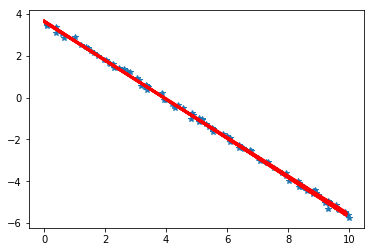

In [120]:
plt.plot(X[:,1],Y,'*')
x_test = np.arange(0,10,0.1)[:,None]
X_test = np.hstack([np.ones((x_test.shape[0],1)),x_test])
for i in range(100):
    sample_mu = mvn(mu_[:,0], Sigma)
    print sample_mu
    y_pred = np.dot(X_test,sample_mu[:-1])
    plt.plot(x_test, y_pred, '-r')

### On Project

In [126]:
X  = np.hstack([np.ones((x_train.shape[0],1)), x_train])
Y = y_train.copy()

In [127]:
alpha = 10000.
#lamda = 1.
params = [alpha]#,lamda]
D_in = X.shape[1]+1
D_out = 1
batch_size = 50
mu_0 = np.random.rand(D_in,1).astype(np.float32)
L_0 = np.eye(D_in).astype(np.float32)

mu = tf.Variable(mu_0.copy())
L = tf.Variable(L_0.copy())

X = X.astype(np.float32)
Y = Y.astype(np.float32)

error_mse = mse(tf.matmul(X,mu[:-1]),Y)
post = posterior(mu,params,X,Y)

samples = tf.placeholder(tf.float32,shape=(batch_size, D_in))

In [144]:
elbo = ELBO(mu,L,samples, params, X, Y)
tf.gradients(elbo,[mu,L])

optimizer = tf.train.AdamOptimizer(0.1)
train = optimizer.minimize(-elbo,var_list=[mu,L])

sess.run(tf.global_variables_initializer())

In [145]:
for i in range(5000):
    cur_samples = np.array([np.random.normal(np.zeros(D_in)) for j in range(batch_size)])
    _,val,elbo_,mu_,e_ = sess.run([train,post, elbo,mu,error_mse],feed_dict={samples:cur_samples})
    print i,val,elbo_,e_

0 [[11668178.]] [[-1.06125926e+09]] 720.8867
1 [[10191848.]] [[-1.1679963e+09]] 788.00214
2 [[7435218.]] [[-1.3247299e+09]] 719.202
3 [[5416385.]] [[-4.63157e+08]] 629.8425
4 [[4180835.5]] [[-3.1433472e+08]] 554.0943
5 [[3542286.]] [[-2.8764298e+08]] 494.18723
6 [[3244491.]] [[-2.036902e+08]] 448.447
7 [[3181678.5]] [[-1.8886035e+08]] 411.10498
8 [[3316838.]] [[-1.2517033e+08]] 383.92276
9 [[3629781.5]] [[-85945640.]] 364.0415
10 [[4096204.]] [[-84326810.]] 349.9678
11 [[4746480.5]] [[-63593964.]] 340.70233
12 [[5772713.]] [[-46456410.]] 335.13336
13 [[8208239.5]] [[-53065864.]] 332.073
14 [[7546757.]] [[-54947736.]] 330.4073
15 [[5839408.]] [[-46311292.]] 329.51263
16 [[4973177.5]] [[-48527972.]] 328.7067
17 [[4495254.5]] [[-45494640.]] 327.56412
18 [[4163853.]] [[-45938156.]] 325.77014
19 [[3957655.2]] [[-39755140.]] 323.99005
20 [[3871149.8]] [[-30223802.]] 321.62823
21 [[3799107.8]] [[-17516532.]] 318.6494
22 [[3689082.]] [[-25685374.]] 315.7819
23 [[3604794.2]] [[-17458800.]] 312.

199 [[2557519.]] [[-4933668.]] 123.31177
200 [[2502802.]] [[-5492283.5]] 122.89115
201 [[2455709.8]] [[-4135697.]] 122.45866
202 [[2399989.]] [[-5244452.5]] 122.04352
203 [[2355244.5]] [[-4193968.8]] 121.61203
204 [[2313424.8]] [[-4693440.5]] 121.20123
205 [[2282003.8]] [[-6081776.]] 120.80492
206 [[2263344.]] [[-5404937.5]] 120.41058
207 [[2243092.]] [[-5848934.5]] 120.01578
208 [[2223176.]] [[-4306203.]] 119.620964
209 [[2207859.]] [[-5259957.5]] 119.227585
210 [[2226276.8]] [[-4602069.5]] 118.84111
211 [[2247923.]] [[-3952772.5]] 118.46205
212 [[2269879.8]] [[-4483030.]] 118.0994
213 [[2291545.8]] [[-4205673.5]] 117.76316
214 [[2312313.2]] [[-4846271.5]] 117.434944
215 [[2333041.8]] [[-5474274.5]] 117.127304
216 [[2357745.5]] [[-4965750.5]] 116.82562
217 [[2369071.]] [[-4755820.5]] 116.51029
218 [[2385901.2]] [[-4500072.]] 116.20522
219 [[2390529.5]] [[-4718722.]] 115.902
220 [[2407251.5]] [[-5072962.]] 115.574646
221 [[2420750.5]] [[-4503900.5]] 115.25411
222 [[2434944.2]] [[-43211

399 [[3004336.2]] [[-6616544.]] 57.660397
400 [[2769282.5]] [[-6021239.]] 56.49973
401 [[2572207.8]] [[-6877953.]] 55.15418
402 [[2414748.5]] [[-7113134.]] 53.828938
403 [[2287813.5]] [[-5930270.]] 52.72683
404 [[2187972.5]] [[-5010523.]] 51.85315
405 [[2104753.2]] [[-5463269.5]] 51.213997
406 [[2025188.5]] [[-4958961.5]] 50.57833
407 [[1958204.2]] [[-4972126.]] 50.031147
408 [[1902904.2]] [[-6030561.5]] 49.589626
409 [[1848439.8]] [[-8998448.]] 49.236454
410 [[1806293.6]] [[-5325646.5]] 49.051086
411 [[1768872.4]] [[-5804592.5]] 48.951122
412 [[1745762.1]] [[-4945130.5]] 48.866886
413 [[1727670.8]] [[-4382582.]] 48.79631
414 [[1714247.]] [[-4961984.]] 48.752598
415 [[1704324.8]] [[-4480968.5]] 48.69592
416 [[1696307.4]] [[-5236207.5]] 48.62923
417 [[1690570.5]] [[-4586112.5]] 48.558506
418 [[1598329.1]] [[-4954712.]] 48.483948
419 [[1525953.8]] [[-4575397.5]] 48.438133
420 [[1468490.6]] [[-4791890.]] 48.38253
421 [[1421861.8]] [[-8759454.]] 48.33574
422 [[1383660.1]] [[-10565741.]] 48

597 [[944604.2]] [[-2002076.5]] 38.046223
598 [[943503.7]] [[-1977086.2]] 38.03024
599 [[942840.6]] [[-2408251.8]] 38.028122
600 [[942698.75]] [[-2008971.9]] 38.033665
601 [[942267.1]] [[-1968191.6]] 38.0313
602 [[941563.1]] [[-1901121.4]] 38.01923
603 [[940222.]] [[-1980791.1]] 37.986435
604 [[938699.6]] [[-2115701.]] 37.94907
605 [[937423.2]] [[-1881488.9]] 37.921093
606 [[936145.94]] [[-2116805.2]] 37.892548
607 [[934464.4]] [[-1929756.1]] 37.85148
608 [[933110.5]] [[-2186360.8]] 37.820454
609 [[932204.44]] [[-2101852.2]] 37.804237
610 [[931392.44]] [[-1927426.5]] 37.79167
611 [[930425.56]] [[-1983027.]] 37.77418
612 [[929472.44]] [[-2045334.1]] 37.75634
613 [[928265.5]] [[-2140725.5]] 37.72962
614 [[926701.7]] [[-1881152.4]] 37.69109
615 [[925065.]] [[-1791167.1]] 37.6501
616 [[923126.]] [[-1767798.8]] 37.597153
617 [[921733.]] [[-1738233.4]] 37.56105
618 [[920463.3]] [[-1900324.6]] 37.52862
619 [[919493.56]] [[-2023245.4]] 37.50646
620 [[918651.1]] [[-1906521.5]] 37.488033
621 [[9

796 [[866737.9]] [[-1556149.4]] 35.25063
797 [[866637.06]] [[-1477638.]] 35.24229
798 [[866326.8]] [[-1382129.1]] 35.227192
799 [[865904.6]] [[-1606386.9]] 35.20746
800 [[865604.25]] [[-1316383.4]] 35.191364
801 [[865351.7]] [[-1350447.4]] 35.176666
802 [[865009.2]] [[-1355863.]] 35.158436
803 [[864568.06]] [[-1499224.8]] 35.13632
804 [[864048.5]] [[-1487615.5]] 35.110878
805 [[863442.25]] [[-1329517.1]] 35.082546
806 [[863007.94]] [[-1437765.]] 35.061626
807 [[862692.]] [[-1525014.]] 35.045513
808 [[862463.44]] [[-1395711.2]] 35.03186
809 [[862349.5]] [[-1369813.5]] 35.02334
810 [[862432.44]] [[-1456802.8]] 35.02402
811 [[862472.6]] [[-1402880.2]] 35.021736
812 [[862455.6]] [[-1492890.5]] 35.01824
813 [[862264.7]] [[-1374273.2]] 35.00585
814 [[862107.6]] [[-1466270.2]] 34.994133
815 [[862001.44]] [[-1376628.6]] 34.984615
816 [[861861.1]] [[-1347777.1]] 34.974037
817 [[861625.7]] [[-1448490.2]] 34.959366
818 [[861535.75]] [[-1351982.5]] 34.950806
819 [[861495.44]] [[-1398818.8]] 34.944

996 [[837575.3]] [[-1276105.2]] 33.988495
997 [[837398.5]] [[-1221323.6]] 33.984634
998 [[837064.9]] [[-1242888.4]] 33.97429
999 [[836737.75]] [[-1189886.6]] 33.962948
1000 [[836456.4]] [[-1175759.4]] 33.953445
1001 [[836302.5]] [[-1205320.8]] 33.949566
1002 [[836220.1]] [[-1197520.6]] 33.948166
1003 [[836277.9]] [[-1224682.8]] 33.95268
1004 [[836405.9]] [[-1199251.4]] 33.959442
1005 [[836519.6]] [[-1203686.2]] 33.965378
1006 [[836499.6]] [[-1162527.6]] 33.96502
1007 [[836605.94]] [[-1217987.4]] 33.968723
1008 [[836769.9]] [[-1238072.]] 33.975464
1009 [[836637.4]] [[-1237178.4]] 33.967796
1010 [[836465.]] [[-1235723.]] 33.958225
1011 [[836294.75]] [[-1238727.9]] 33.949837
1012 [[836264.]] [[-1313845.1]] 33.94726
1013 [[836173.06]] [[-1181099.6]] 33.941814
1014 [[835980.94]] [[-1214313.1]] 33.93229
1015 [[835994.06]] [[-1255409.5]] 33.931282
1016 [[835995.7]] [[-1216607.1]] 33.929935
1017 [[835885.25]] [[-1205242.2]] 33.923588
1018 [[835817.06]] [[-1163277.1]] 33.919674
1019 [[835710.9]

1191 [[822306.2]] [[-1112812.6]] 33.48382
1192 [[822261.94]] [[-1045908.8]] 33.483315
1193 [[822223.75]] [[-1136008.6]] 33.483456
1194 [[822084.8]] [[-1090775.2]] 33.478966
1195 [[821841.1]] [[-1093622.2]] 33.469887
1196 [[821669.2]] [[-1110481.1]] 33.464317
1197 [[821503.44]] [[-1087777.5]] 33.459625
1198 [[821345.6]] [[-1078487.4]] 33.455833
1199 [[821224.56]] [[-1128156.5]] 33.453365
1200 [[821144.75]] [[-1111244.1]] 33.452133
1201 [[821100.5]] [[-1130120.8]] 33.45326
1202 [[821080.8]] [[-1110861.2]] 33.45451
1203 [[821116.06]] [[-1072569.1]] 33.457417
1204 [[821054.5]] [[-1083470.5]] 33.45607
1205 [[820952.7]] [[-1167238.8]] 33.45295
1206 [[820772.6]] [[-1114315.5]] 33.447693
1207 [[820597.6]] [[-1154304.1]] 33.443115
1208 [[820441.5]] [[-1105440.1]] 33.438606
1209 [[820341.3]] [[-1136190.9]] 33.43608
1210 [[820331.25]] [[-1110667.4]] 33.43694
1211 [[820297.4]] [[-1102199.8]] 33.43637
1212 [[820317.9]] [[-1137576.1]] 33.438152
1213 [[820316.06]] [[-1128690.1]] 33.438866
1214 [[8202

1386 [[808818.56]] [[-1067137.9]] 33.22088
1387 [[808781.7]] [[-1077441.8]] 33.21812
1388 [[808752.56]] [[-1112494.2]] 33.215385
1389 [[808780.8]] [[-1136840.1]] 33.214706
1390 [[808799.94]] [[-1086550.]] 33.21364
1391 [[808812.]] [[-1063557.2]] 33.212513
1392 [[808850.4]] [[-1073875.5]] 33.21226
1393 [[808899.5]] [[-1032150.3]] 33.21229
1394 [[808927.06]] [[-1040541.]] 33.21181
1395 [[808919.7]] [[-1065984.9]] 33.210682
1396 [[808946.06]] [[-1091557.8]] 33.210857
1397 [[809011.25]] [[-1084779.9]] 33.212822
1398 [[809058.8]] [[-1030610.94]] 33.215115
1399 [[809152.06]] [[-1075852.5]] 33.21894
1400 [[809182.6]] [[-1048063.4]] 33.220455
1401 [[809132.25]] [[-1081884.4]] 33.219063
1402 [[809047.7]] [[-1069440.5]] 33.217033
1403 [[808994.6]] [[-1088893.5]] 33.21603
1404 [[809034.5]] [[-1058378.8]] 33.218956
1405 [[809097.4]] [[-1070706.8]] 33.223053
1406 [[809063.94]] [[-1039847.25]] 33.223137
1407 [[809103.]] [[-1015155.06]] 33.225624
1408 [[808960.25]] [[-1036626.8]] 33.22022
1409 [[8088

1581 [[801634.1]] [[-994062.44]] 33.069447
1582 [[801611.6]] [[-1024685.94]] 33.06847
1583 [[801597.4]] [[-1014228.44]] 33.067413
1584 [[801615.2]] [[-1038128.8]] 33.067314
1585 [[801679.56]] [[-1022823.7]] 33.069534
1586 [[801800.44]] [[-1041082.1]] 33.07407
1587 [[801873.4]] [[-1003048.94]] 33.0765
1588 [[801934.1]] [[-1008448.1]] 33.078434
1589 [[801961.75]] [[-1018859.5]] 33.079433
1590 [[802092.9]] [[-1025452.8]] 33.08479
1591 [[802065.7]] [[-992600.3]] 33.083363
1592 [[801897.6]] [[-1033207.94]] 33.07646
1593 [[801705.]] [[-1013437.25]] 33.069157
1594 [[801585.4]] [[-1027923.6]] 33.06483
1595 [[801581.9]] [[-983149.2]] 33.06513
1596 [[801651.3]] [[-997057.06]] 33.068436
1597 [[801741.4]] [[-978072.25]] 33.072258
1598 [[801822.3]] [[-1043439.]] 33.075584
1599 [[801904.8]] [[-1042869.75]] 33.078854
1600 [[801791.8]] [[-994175.75]] 33.074257
1601 [[801703.3]] [[-1028319.9]] 33.071083
1602 [[801609.5]] [[-997510.8]] 33.068104
1603 [[801547.7]] [[-1003024.8]] 33.066597
1604 [[801438.2

1775 [[797202.56]] [[-982208.1]] 32.960934
1776 [[797112.25]] [[-977874.44]] 32.95768
1777 [[797093.3]] [[-957328.3]] 32.957733
1778 [[797164.94]] [[-981517.6]] 32.961197
1779 [[797224.44]] [[-984457.94]] 32.964516
1780 [[797179.1]] [[-974527.94]] 32.964054
1781 [[797053.25]] [[-982879.1]] 32.960922
1782 [[796882.94]] [[-973392.56]] 32.95589
1783 [[796767.]] [[-966714.8]] 32.953182
1784 [[796670.9]] [[-1007071.9]] 32.951504
1785 [[796663.94]] [[-965174.8]] 32.953262
1786 [[796685.5]] [[-988569.06]] 32.956013
1787 [[796752.7]] [[-977462.6]] 32.960457
1788 [[796784.06]] [[-999244.44]] 32.963802
1789 [[796644.5]] [[-969151.44]] 32.960503
1790 [[796561.]] [[-969881.]] 32.959396
1791 [[796404.3]] [[-980222.06]] 32.95549
1792 [[796176.6]] [[-934475.3]] 32.948734
1793 [[795971.75]] [[-979811.94]] 32.94256
1794 [[795853.25]] [[-970046.06]] 32.94002
1795 [[795813.7]] [[-974778.06]] 32.940735
1796 [[795918.44]] [[-948947.9]] 32.94729
1797 [[796254.2]] [[-959265.25]] 32.963116
1798 [[796613.3]] [

1971 [[791334.25]] [[-965993.06]] 32.84218
1972 [[791338.1]] [[-942797.44]] 32.84244
1973 [[791268.5]] [[-941210.3]] 32.84024
1974 [[791222.4]] [[-939795.2]] 32.83858
1975 [[791200.6]] [[-946679.6]] 32.83762
1976 [[791220.44]] [[-936238.3]] 32.83816
1977 [[791277.9]] [[-941450.56]] 32.840015
1978 [[791365.25]] [[-932090.7]] 32.84349
1979 [[791451.2]] [[-930988.94]] 32.846928
1980 [[791676.6]] [[-946203.56]] 32.85548
1981 [[791632.9]] [[-957177.2]] 32.85326
1982 [[791709.8]] [[-925768.06]] 32.855732
1983 [[791525.94]] [[-963594.56]] 32.847992
1984 [[791387.4]] [[-940728.56]] 32.84178
1985 [[791364.5]] [[-950900.9]] 32.84032
1986 [[791403.1]] [[-941651.5]] 32.841045
1987 [[791422.4]] [[-946751.25]] 32.84129
1988 [[791389.44]] [[-937628.6]] 32.839657
1989 [[791310.7]] [[-945595.4]] 32.836266
1990 [[791272.44]] [[-929754.06]] 32.83446
1991 [[791210.2]] [[-963564.]] 32.831676
1992 [[791143.8]] [[-943217.6]] 32.829185
1993 [[791133.9]] [[-964078.7]] 32.828808
1994 [[791144.75]] [[-942037.4]]

2169 [[786654.9]] [[-906388.25]] 32.73221
2170 [[786812.9]] [[-907699.06]] 32.738693
2171 [[787064.]] [[-936080.06]] 32.748688
2172 [[787203.44]] [[-905670.1]] 32.75451
2173 [[787206.25]] [[-913204.56]] 32.755352
2174 [[786877.9]] [[-904446.6]] 32.743572
2175 [[786657.75]] [[-909876.25]] 32.73613
2176 [[786610.44]] [[-910212.6]] 32.73516
2177 [[786778.3]] [[-916960.75]] 32.741924
2178 [[786998.5]] [[-938264.5]] 32.7509
2179 [[787265.06]] [[-896747.9]] 32.76158
2180 [[787362.6]] [[-908545.9]] 32.76586
2181 [[787302.]] [[-926216.]] 32.76391
2182 [[786951.1]] [[-916931.75]] 32.750935
2183 [[786537.]] [[-916199.44]] 32.735783
2184 [[786293.75]] [[-920058.25]] 32.726917
2185 [[786240.9]] [[-912063.94]] 32.725018
2186 [[786378.9]] [[-909477.7]] 32.730114
2187 [[786692.25]] [[-931319.1]] 32.74148
2188 [[786793.3]] [[-924117.75]] 32.74498
2189 [[786777.3]] [[-926271.9]] 32.74424
2190 [[786360.8]] [[-938382.25]] 32.728157
2191 [[786224.4]] [[-920601.6]] 32.722607
2192 [[786230.25]] [[-905564.8]

2366 [[783586.06]] [[-883403.8]] 32.64775
2367 [[783235.5]] [[-888824.1]] 32.634605
2368 [[783098.8]] [[-908828.4]] 32.6292
2369 [[783241.6]] [[-882203.44]] 32.634476
2370 [[783734.44]] [[-893528.6]] 32.652798
2371 [[784244.75]] [[-895874.]] 32.672
2372 [[784409.8]] [[-910975.5]] 32.67811
2373 [[784334.06]] [[-888990.1]] 32.675354
2374 [[784085.6]] [[-875749.25]] 32.666054
2375 [[783714.2]] [[-894150.5]] 32.652134
2376 [[783420.25]] [[-892373.3]] 32.641174
2377 [[783151.1]] [[-903192.3]] 32.630836
2378 [[783343.]] [[-901539.]] 32.63787
2379 [[783915.4]] [[-895379.7]] 32.659424
2380 [[784196.75]] [[-894689.8]] 32.670082
2381 [[784051.06]] [[-899825.7]] 32.66486
2382 [[783558.3]] [[-882766.94]] 32.64661
2383 [[783265.06]] [[-894334.06]] 32.635838
2384 [[783239.25]] [[-892675.94]] 32.635044
2385 [[783359.94]] [[-893342.56]] 32.63929
2386 [[783603.2]] [[-899198.1]] 32.64854
2387 [[783954.6]] [[-905621.94]] 32.6619
2388 [[784084.4]] [[-884081.1]] 32.66727
2389 [[783874.56]] [[-907535.94]] 3

2561 [[779536.]] [[-883572.56]] 32.53651
2562 [[779579.1]] [[-891464.25]] 32.538116
2563 [[779548.4]] [[-884093.44]] 32.537025
2564 [[779515.25]] [[-874513.9]] 32.535866
2565 [[779499.1]] [[-875992.8]] 32.535297
2566 [[779501.06]] [[-883574.8]] 32.535038
2567 [[779492.4]] [[-871858.4]] 32.534615
2568 [[779510.56]] [[-873984.75]] 32.53512
2569 [[779523.4]] [[-895079.9]] 32.53546
2570 [[779508.25]] [[-891475.9]] 32.534595
2571 [[779486.2]] [[-878555.5]] 32.533463
2572 [[779455.5]] [[-892663.25]] 32.532173
2573 [[779446.94]] [[-885267.3]] 32.53168
2574 [[779441.]] [[-874756.9]] 32.531258
2575 [[779497.06]] [[-903608.4]] 32.53309
2576 [[779615.94]] [[-899380.3]] 32.53712
2577 [[779616.4]] [[-866137.06]] 32.536945
2578 [[779622.75]] [[-877501.25]] 32.537144
2579 [[779622.]] [[-904977.5]] 32.537083
2580 [[779505.6]] [[-895560.9]] 32.53285
2581 [[779401.3]] [[-871465.1]] 32.529034
2582 [[779338.]] [[-887125.6]] 32.526733
2583 [[779293.44]] [[-872379.]] 32.525173
2584 [[779355.06]] [[-884683.3

2756 [[777441.56]] [[-873716.]] 32.45671
2757 [[777560.5]] [[-869149.25]] 32.46026
2758 [[777868.75]] [[-876176.3]] 32.471012
2759 [[778052.25]] [[-863394.7]] 32.477165
2760 [[778021.06]] [[-872626.25]] 32.47568
2761 [[777825.56]] [[-870868.1]] 32.46827
2762 [[777486.44]] [[-884680.]] 32.455727
2763 [[777373.75]] [[-855517.8]] 32.45141
2764 [[777426.5]] [[-866759.44]] 32.45337
2765 [[777489.9]] [[-871019.75]] 32.455845
2766 [[777422.6]] [[-864587.8]] 32.453926
2767 [[777322.]] [[-875631.3]] 32.45055
2768 [[777141.1]] [[-879856.1]] 32.44413
2769 [[777073.9]] [[-864998.4]] 32.44192
2770 [[777194.6]] [[-865014.94]] 32.446754
2771 [[777505.75]] [[-866527.06]] 32.458416
2772 [[777934.06]] [[-871492.4]] 32.47459
2773 [[778249.9]] [[-853697.4]] 32.486618
2774 [[778365.75]] [[-864850.3]] 32.491173
2775 [[778178.9]] [[-864774.25]] 32.484764
2776 [[777361.94]] [[-860725.75]] 32.45512
2777 [[777009.4]] [[-873670.7]] 32.442356
2778 [[776934.6]] [[-860768.06]] 32.439575
2779 [[777364.75]] [[-864438

2953 [[774840.94]] [[-848052.6]] 32.384716
2954 [[774822.6]] [[-862564.3]] 32.38445
2955 [[774642.7]] [[-850800.06]] 32.37805
2956 [[774582.56]] [[-848811.1]] 32.37596
2957 [[774970.5]] [[-843816.1]] 32.390133
2958 [[775433.1]] [[-853355.8]] 32.407085
2959 [[775468.94]] [[-863456.94]] 32.408646
2960 [[775183.1]] [[-858321.9]] 32.39842
2961 [[774853.94]] [[-859914.06]] 32.386677
2962 [[774717.8]] [[-843531.56]] 32.38185
2963 [[774585.6]] [[-858049.2]] 32.377148
2964 [[774459.94]] [[-850819.94]] 32.372574
2965 [[774404.6]] [[-859508.94]] 32.370655
2966 [[774499.7]] [[-858451.75]] 32.374107
2967 [[774811.94]] [[-840354.3]] 32.385452
2968 [[775000.3]] [[-861174.8]] 32.392216
2969 [[774869.9]] [[-861540.75]] 32.387413
2970 [[774486.]] [[-851389.44]] 32.37352
2971 [[774294.44]] [[-852405.25]] 32.366695
2972 [[774459.94]] [[-847895.8]] 32.372616
2973 [[774618.2]] [[-849624.3]] 32.378067
2974 [[774662.8]] [[-848828.06]] 32.379486
2975 [[774668.4]] [[-860819.8]] 32.37934
2976 [[774561.4]] [[-85

3152 [[772338.44]] [[-836607.2]] 32.30292
3153 [[772233.8]] [[-848296.3]] 32.299767
3154 [[772132.06]] [[-834991.6]] 32.296837
3155 [[772078.5]] [[-843592.75]] 32.295456
3156 [[772127.]] [[-827083.5]] 32.29774
3157 [[772104.44]] [[-834285.7]] 32.297504
3158 [[772084.9]] [[-844502.25]] 32.297226
3159 [[772027.44]] [[-849902.25]] 32.295437
3160 [[771997.75]] [[-838553.]] 32.29462
3161 [[772076.]] [[-834019.94]] 32.297466
3162 [[772092.7]] [[-852624.6]] 32.298286
3163 [[772111.94]] [[-856663.]] 32.29914
3164 [[772014.6]] [[-846297.7]] 32.295574
3165 [[771897.9]] [[-836435.3]] 32.29125
3166 [[771851.94]] [[-851414.8]] 32.289486
3167 [[771913.75]] [[-833723.7]] 32.291687
3168 [[771923.75]] [[-843350.8]] 32.291965
3169 [[771875.4]] [[-854562.25]] 32.290375
3170 [[771903.75]] [[-845516.]] 32.29148
3171 [[772043.8]] [[-831842.56]] 32.29634
3172 [[772091.5]] [[-837512.94]] 32.297966
3173 [[772146.44]] [[-841056.56]] 32.299767
3174 [[772115.44]] [[-845562.2]] 32.298634
3175 [[772190.06]] [[-8457

3351 [[769788.75]] [[-837057.1]] 32.22761
3352 [[769747.06]] [[-826397.3]] 32.226166
3353 [[769713.3]] [[-827062.75]] 32.22502
3354 [[769735.3]] [[-834908.44]] 32.22588
3355 [[769911.6]] [[-837231.4]] 32.23226
3356 [[770252.9]] [[-837476.4]] 32.244415
3357 [[770499.56]] [[-822590.9]] 32.25328
3358 [[770380.1]] [[-828030.]] 32.2491
3359 [[770186.06]] [[-824033.94]] 32.242256
3360 [[770003.8]] [[-827518.8]] 32.235786
3361 [[769838.44]] [[-825154.]] 32.229797
3362 [[769734.75]] [[-826780.2]] 32.22617
3363 [[769794.75]] [[-832595.8]] 32.228184
3364 [[769711.06]] [[-852812.5]] 32.225113
3365 [[769693.25]] [[-821922.6]] 32.224537
3366 [[769737.75]] [[-833402.06]] 32.226192
3367 [[769838.1]] [[-839012.44]] 32.22976
3368 [[769883.3]] [[-830374.75]] 32.231407
3369 [[770075.8]] [[-831336.25]] 32.238113
3370 [[770231.75]] [[-826134.8]] 32.243492
3371 [[770398.25]] [[-844306.2]] 32.24916
3372 [[770130.25]] [[-838932.]] 32.239506
3373 [[769739.56]] [[-830052.8]] 32.22554
3374 [[769694.4]] [[-838090

3548 [[768045.5]] [[-836048.8]] 32.162018
3549 [[768007.5]] [[-824262.9]] 32.161148
3550 [[768000.06]] [[-830474.7]] 32.161316
3551 [[768157.25]] [[-819978.3]] 32.167114
3552 [[768301.1]] [[-812183.3]] 32.172405
3553 [[768304.56]] [[-823222.2]] 32.172634
3554 [[768074.3]] [[-821152.6]] 32.164684
3555 [[767961.6]] [[-816423.4]] 32.16078
3556 [[767950.5]] [[-829892.56]] 32.160473
3557 [[767940.75]] [[-818748.5]] 32.160294
3558 [[767896.4]] [[-818110.2]] 32.159023
3559 [[767866.4]] [[-824564.8]] 32.1584
3560 [[767889.4]] [[-828289.6]] 32.159573
3561 [[767913.3]] [[-822240.94]] 32.160683
3562 [[767925.3]] [[-840325.8]] 32.161335
3563 [[767920.25]] [[-822633.7]] 32.161507
3564 [[767882.06]] [[-827282.5]] 32.1605
3565 [[767796.7]] [[-819085.7]] 32.157898
3566 [[767894.6]] [[-822369.94]] 32.16178
3567 [[767960.8]] [[-823136.9]] 32.16451
3568 [[767829.75]] [[-822325.6]] 32.16019
3569 [[767828.25]] [[-818853.6]] 32.16029
3570 [[767886.8]] [[-819751.5]] 32.16257
3571 [[768002.7]] [[-825928.7]] 3

3746 [[766472.4]] [[-818555.3]] 32.113777
3747 [[766563.2]] [[-823097.75]] 32.11693
3748 [[766314.75]] [[-814891.8]] 32.10804
3749 [[766162.5]] [[-820704.75]] 32.102665
3750 [[766294.2]] [[-807727.7]] 32.107464
3751 [[766452.94]] [[-815637.8]] 32.113068
3752 [[766405.06]] [[-822821.4]] 32.11144
3753 [[766286.]] [[-822172.3]] 32.10718
3754 [[766019.5]] [[-817926.8]] 32.097885
3755 [[766110.]] [[-815988.1]] 32.1012
3756 [[766900.3]] [[-815249.9]] 32.12927
3757 [[767412.4]] [[-811949.5]] 32.14736
3758 [[766888.5]] [[-812617.4]] 32.128845
3759 [[766520.8]] [[-810672.25]] 32.11569
3760 [[766233.1]] [[-814755.06]] 32.105587
3761 [[766151.5]] [[-823640.56]] 32.102684
3762 [[766498.4]] [[-818271.7]] 32.114754
3763 [[766565.]] [[-820646.06]] 32.11695
3764 [[766573.75]] [[-806129.56]] 32.1171
3765 [[766930.4]] [[-814538.6]] 32.12958
3766 [[767316.5]] [[-810807.44]] 32.14309
3767 [[767499.7]] [[-811081.44]] 32.14939
3768 [[766969.06]] [[-816993.75]] 32.130367
3769 [[766294.9]] [[-823206.8]] 32.10

3941 [[764118.6]] [[-812796.4]] 32.038395
3942 [[764160.3]] [[-805982.1]] 32.03993
3943 [[764181.75]] [[-809421.2]] 32.04079
3944 [[764138.56]] [[-799863.6]] 32.03915
3945 [[764105.25]] [[-808487.2]] 32.037975
3946 [[764090.5]] [[-805705.44]] 32.03741
3947 [[764094.9]] [[-802456.7]] 32.037605
3948 [[764303.75]] [[-806878.2]] 32.04487
3949 [[764608.5]] [[-811747.8]] 32.05534
3950 [[764612.56]] [[-802548.25]] 32.05547
3951 [[764406.25]] [[-806733.8]] 32.048214
3952 [[764192.5]] [[-809741.06]] 32.04065
3953 [[764409.6]] [[-808434.75]] 32.048286
3954 [[764830.1]] [[-806585.1]] 32.06302
3955 [[764909.6]] [[-803612.44]] 32.065834
3956 [[764933.7]] [[-807435.7]] 32.066563
3957 [[764983.56]] [[-806638.2]] 32.068203
3958 [[764800.56]] [[-805645.]] 32.06161
3959 [[764526.9]] [[-812392.94]] 32.051907
3960 [[764523.1]] [[-813215.7]] 32.05173
3961 [[764750.5]] [[-811303.5]] 32.059635
3962 [[764841.3]] [[-815917.5]] 32.062866
3963 [[764717.4]] [[-800574.]] 32.05864
3964 [[764588.7]] [[-808255.3]] 32

4138 [[762402.8]] [[-802334.5]] 31.980661
4139 [[762407.75]] [[-800024.75]] 31.980549
4140 [[762410.4]] [[-803747.5]] 31.980303
4141 [[762525.75]] [[-799295.1]] 31.984213
4142 [[762658.9]] [[-799869.]] 31.98858
4143 [[762711.4]] [[-794617.5]] 31.990261
4144 [[762696.25]] [[-804424.75]] 31.989557
4145 [[762431.44]] [[-801275.25]] 31.98011
4146 [[762498.56]] [[-801964.2]] 31.9822
4147 [[763156.]] [[-798961.8]] 32.004997
4148 [[763241.1]] [[-805857.25]] 32.007923
4149 [[762792.4]] [[-800608.56]] 31.992104
4150 [[762388.7]] [[-803745.94]] 31.978077
4151 [[762310.8]] [[-804882.6]] 31.975395
4152 [[762346.44]] [[-799053.5]] 31.976748
4153 [[762492.7]] [[-806056.]] 31.981913
4154 [[762452.25]] [[-807377.7]] 31.980732
4155 [[762420.94]] [[-800994.3]] 31.979872
4156 [[762401.]] [[-797272.6]] 31.979307
4157 [[762755.2]] [[-800087.]] 31.991772
4158 [[763259.7]] [[-801255.94]] 32.009384
4159 [[763227.3]] [[-809141.3]] 32.008434
4160 [[762555.25]] [[-803119.25]] 31.985126
4161 [[762125.]] [[-810352

4333 [[760879.4]] [[-799144.9]] 31.928616
4334 [[761238.75]] [[-800970.75]] 31.941175
4335 [[760890.6]] [[-798176.3]] 31.929264
4336 [[760480.25]] [[-799410.75]] 31.91502
4337 [[760407.8]] [[-792986.2]] 31.912735
4338 [[760592.25]] [[-798286.]] 31.919218
4339 [[760821.5]] [[-803301.06]] 31.927334
4340 [[760767.44]] [[-796461.7]] 31.925594
4341 [[760588.94]] [[-799631.2]] 31.91952
4342 [[760442.6]] [[-798168.94]] 31.91452
4343 [[760437.]] [[-794396.1]] 31.914377
4344 [[760441.5]] [[-795456.7]] 31.91439
4345 [[760568.2]] [[-796475.6]] 31.918837
4346 [[760597.7]] [[-800005.94]] 31.919823
4347 [[760504.9]] [[-792708.6]] 31.916605
4348 [[760420.8]] [[-804021.7]] 31.913626
4349 [[760431.2]] [[-801465.94]] 31.91389
4350 [[760534.75]] [[-791406.4]] 31.917482
4351 [[760457.94]] [[-796422.2]] 31.915009
4352 [[760336.5]] [[-797150.5]] 31.91091
4353 [[760293.44]] [[-794667.56]] 31.90948
4354 [[760252.25]] [[-794914.44]] 31.908138
4355 [[760284.2]] [[-802399.75]] 31.909344
4356 [[760638.25]] [[-794

4530 [[758708.4]] [[-788517.9]] 31.852182
4531 [[758772.1]] [[-791960.75]] 31.854261
4532 [[758964.06]] [[-792117.6]] 31.860748
4533 [[759214.25]] [[-787424.5]] 31.869312
4534 [[759252.7]] [[-789165.1]] 31.870623
4535 [[759126.06]] [[-792021.75]] 31.866177
4536 [[758926.]] [[-788942.7]] 31.859224
4537 [[758781.56]] [[-793765.56]] 31.854385
4538 [[758990.94]] [[-790616.6]] 31.861906
4539 [[759198.9]] [[-798335.]] 31.869442
4540 [[759113.8]] [[-794727.7]] 31.866924
4541 [[758735.3]] [[-789827.9]] 31.854053
4542 [[758621.9]] [[-792646.75]] 31.8504
4543 [[758700.25]] [[-796709.7]] 31.853403
4544 [[758950.7]] [[-789214.94]] 31.862446
4545 [[759095.1]] [[-791304.9]] 31.867716
4546 [[758916.75]] [[-791131.8]] 31.861874
4547 [[758480.75]] [[-789495.2]] 31.847065
4548 [[758356.5]] [[-791809.]] 31.842836
4549 [[758535.94]] [[-793008.75]] 31.849215
4550 [[758929.9]] [[-790382.4]] 31.862923
4551 [[759146.44]] [[-794868.25]] 31.870577
4552 [[758788.06]] [[-793622.44]] 31.858274
4553 [[758308.4]] [[

4725 [[756684.75]] [[-784578.7]] 31.78585
4726 [[756787.6]] [[-786735.06]] 31.789408
4727 [[756978.6]] [[-788525.06]] 31.796066
4728 [[757381.4]] [[-786417.6]] 31.81001
4729 [[756955.75]] [[-786149.3]] 31.795269
4730 [[756568.3]] [[-785325.06]] 31.781939
4731 [[756787.7]] [[-785807.9]] 31.789598
4732 [[757048.94]] [[-782554.2]] 31.798647
4733 [[756942.9]] [[-786958.]] 31.794954
4734 [[756565.5]] [[-790940.3]] 31.781933
4735 [[756772.75]] [[-791403.56]] 31.788986
4736 [[757321.56]] [[-787923.75]] 31.807886
4737 [[757285.1]] [[-792380.9]] 31.806538
4738 [[756610.5]] [[-784980.75]] 31.783024
4739 [[756854.44]] [[-787226.4]] 31.791351
4740 [[757590.44]] [[-786739.44]] 31.816698
4741 [[757788.4]] [[-787563.8]] 31.823538
4742 [[757389.6]] [[-785384.75]] 31.809717
4743 [[756768.56]] [[-788451.44]] 31.788065
4744 [[756794.6]] [[-788799.3]] 31.788887
4745 [[756844.2]] [[-782821.06]] 31.790573
4746 [[756929.25]] [[-785026.]] 31.793476
4747 [[756755.]] [[-786318.6]] 31.787384
4748 [[756981.56]] [

4919 [[754598.75]] [[-780522.56]] 31.716976
4920 [[754555.9]] [[-778621.3]] 31.715544
4921 [[754698.1]] [[-778893.6]] 31.720337
4922 [[754950.1]] [[-783149.3]] 31.728851
4923 [[754841.3]] [[-778719.3]] 31.725052
4924 [[754542.06]] [[-776733.2]] 31.714622
4925 [[754613.6]] [[-789300.25]] 31.717052
4926 [[754840.7]] [[-780797.2]] 31.724688
4927 [[754765.6]] [[-787612.3]] 31.722021
4928 [[754610.1]] [[-781899.5]] 31.716534
4929 [[754563.75]] [[-778709.44]] 31.714811
4930 [[754641.75]] [[-782111.75]] 31.717386
4931 [[754869.25]] [[-781135.6]] 31.725002
4932 [[754758.56]] [[-782623.]] 31.721046
4933 [[754598.9]] [[-780448.5]] 31.715366
4934 [[754536.56]] [[-780642.25]] 31.713007
4935 [[754541.1]] [[-780346.7]] 31.712996
4936 [[754566.75]] [[-779120.7]] 31.713774
4937 [[754673.1]] [[-780433.4]] 31.717314
4938 [[754472.4]] [[-776685.3]] 31.710264
4939 [[754436.75]] [[-783480.7]] 31.708948
4940 [[754672.94]] [[-781052.1]] 31.717058
4941 [[755040.56]] [[-779074.9]] 31.729813
4942 [[755003.]] [[

In [146]:
mu_ = mu.eval()

In [147]:
1/(mu_[-1]**2)

array([0.7605298], dtype=float32)

In [148]:
mu_

array([[19.041403  ],
       [38.023655  ],
       [ 6.0295725 ],
       [-0.893028  ],
       [ 0.8320028 ],
       [ 6.3162985 ],
       [ 3.9039643 ],
       [ 2.5006843 ],
       [ 0.30474198],
       [ 0.14309709],
       [-0.44322246],
       [-0.5455557 ],
       [ 0.09455126],
       [ 0.6839073 ],
       [-0.24652265],
       [ 2.6259768 ],
       [-0.32827353],
       [-0.2059546 ],
       [ 0.77015823],
       [-0.2721953 ],
       [ 0.03907469],
       [ 0.08224465],
       [-1.146679  ]], dtype=float32)

In [149]:
Sigma = expm(2*L).eval()

In [150]:
print Sigma

[[ 1.29225224e-01  9.11455136e-03  6.46626251e-03 -1.01414025e-01
  -8.92499834e-02  8.74798596e-02 -3.22307199e-02 -4.45728377e-02
  -1.52742211e-02 -1.52600901e-02 -1.38215953e-02 -7.91749917e-03
  -1.85578000e-02  5.60470410e-02 -1.86320711e-02  6.92978268e-04
   1.47670438e-03 -5.08420926e-04 -6.82454614e-04  4.08485648e-04
  -1.41501380e-03 -9.51772206e-04 -4.23626450e-04]
 [ 9.11456067e-03  3.48689370e-02 -2.43635159e-02 -3.04576964e-03
  -1.16126454e-02 -2.02731937e-02 -2.33370811e-02  3.41479257e-02
  -1.51738273e-02 -8.22664145e-03  2.25437265e-02 -5.51307900e-03
  -3.43174418e-03  4.30880953e-03  4.24641185e-03  4.36489587e-04
  -1.84708260e-04 -3.96485266e-05 -1.67834543e-04 -1.60083713e-04
  -1.02576661e-04  7.44296922e-05  3.12116827e-05]
 [ 6.46627788e-03 -2.43634973e-02  3.75383049e-02 -1.23475876e-03
   5.16041508e-03  9.18276887e-03  1.48089705e-02 -2.88013853e-02
   1.56417359e-02  1.94169916e-02 -2.67433729e-02  5.63466921e-03
   1.52478153e-02  1.34190172e-02 -1.198

In [151]:
sample_mu = mvn(mu_[:,0], Sigma)

err = mean_squared_error(np.dot(X,sample_mu),Y)/y_var
print err

/home/teguh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  """Entry point for launching an IPython kernel.


ValueError: shapes (44484,22) and (23,) not aligned: 22 (dim 1) != 23 (dim 0)

In [152]:
from sklearn.metrics import mean_squared_error
mean_squared_error(np.dot(X,mu_[:-1]),Y)/y_var

0.07566912772225451

In [263]:
w_standard

array([[ 4.21526690e+01],
       [ 2.70141224e+01],
       [ 7.69731909e+00],
       [-7.67042577e+00],
       [-1.29255909e+01],
       [ 5.52910732e+00],
       [ 7.39404566e+00],
       [-5.53190982e+00],
       [ 3.05572363e-01],
       [ 1.46859020e-01],
       [-3.11154562e-01],
       [-5.85181994e-01],
       [ 2.52675725e-02],
       [ 5.83589600e-01],
       [-3.15188315e-01],
       [ 2.53505246e+00],
       [-2.99511857e-01],
       [-2.48126062e-01],
       [ 6.59295434e-01],
       [-2.78971499e-01],
       [ 8.64115669e-02],
       [ 7.32246785e-03]])

In [720]:
for i in range(1000):
    mu = mu - 0.1*np.dot(np.linalg.inv(hess_w(mu)),grad_w(mu))
    #mu = mu - 0.01*grad_w(mu)
    print mu

[ 4.93226966e+00  3.23086008e+00  1.17066038e+00  1.56952031e-02
 -7.91158225e-01  8.00360341e-01  1.62114568e+00 -4.87867532e-02
  3.96727201e-01  9.00760213e-02  4.52404736e-01 -3.03183419e-03
  7.43696259e-01  8.86627134e-01  5.11650975e-01  8.71101864e-01
  6.59009578e-01  5.83728303e-01  6.29353696e-01  8.04238976e-01
  2.00823029e-01  7.25749846e-02]
[ 8.65431077  5.60918569  1.82332601 -0.75291755 -2.00460221  1.27323492
  2.1984359  -0.5970998   0.38761171  0.09575428  0.37604879 -0.06124686
  0.67185335  0.85632341  0.42896703  1.03749692  0.56315744  0.50054286
  0.63234786  0.69591793  0.18938188  0.06604973]
[12.00414759  7.74967882  2.4107251  -1.44466894 -3.09670169  1.69882205
  2.71799707 -1.09058145  0.37940777  0.10086472  0.30732844 -0.11364038
  0.60719474  0.82905006  0.35455147  1.18725247  0.47689051  0.42567597
  0.63504262  0.59842898  0.17908485  0.06017699]
[15.01900056  9.67612272  2.9393843  -2.06724512 -4.07959112  2.08185049
  3.1856021  -1.53471485  0.37

[ 4.07326314e+01  2.61067437e+01  7.44831289e+00 -7.37718380e+00
 -1.24626356e+01  5.34869592e+00  7.17379741e+00 -5.32271673e+00
  3.09050098e-01  1.44692570e-01 -2.82023270e-01 -5.62971776e-01
  5.26770501e-02  5.95151177e-01 -2.83642721e-01  2.47156936e+00
 -2.62942313e-01 -2.16389112e-01  6.58153109e-01 -2.37644808e-01
  9.07765914e-02  9.81199173e-03]
[ 4.08746346e+01  2.61974818e+01  7.47321344e+00 -7.40650784e+00
 -1.25089308e+01  5.36673707e+00  7.19582217e+00 -5.34363587e+00
  3.08702325e-01  1.44909212e-01 -2.84936404e-01 -5.65192797e-01
  4.99361014e-02  5.93995024e-01 -2.86797280e-01  2.47791767e+00
 -2.66599268e-01 -2.19562805e-01  6.58267344e-01 -2.41777477e-01
  9.03400882e-02  9.56304093e-03]
[ 4.10024375e+01  2.62791461e+01  7.49562393e+00 -7.43289946e+00
 -1.25505965e+01  5.38297411e+00  7.21564446e+00 -5.36246309e+00
  3.08389328e-01  1.45104190e-01 -2.87558224e-01 -5.67191716e-01
  4.74692478e-02  5.92954487e-01 -2.89636383e-01  2.48363115e+00
 -2.69890528e-01 -2.22

[ 4.20984861e+01  2.69795065e+01  7.68781837e+00 -7.65923616e+00
 -1.29079249e+01  5.52222438e+00  7.38564203e+00 -5.52392673e+00
  3.05705043e-01  1.46776354e-01 -3.10043182e-01 -5.84334616e-01
  2.63133034e-02  5.84030737e-01 -3.13984772e-01  2.53263047e+00
 -2.98116664e-01 -2.46915219e-01  6.59251876e-01 -2.77394802e-01
  8.65780935e-02  7.41746626e-03]
[ 4.21039038e+01  2.69829684e+01  7.68876838e+00 -7.66035493e+00
 -1.29096912e+01  5.52291269e+00  7.38648232e+00 -5.52472483e+00
  3.05691774e-01  1.46784619e-01 -3.10154323e-01 -5.84419353e-01
  2.62087307e-02  5.83986627e-01 -3.14105125e-01  2.53287267e+00
 -2.98256184e-01 -2.47036302e-01  6.59256235e-01 -2.77552471e-01
  8.65614400e-02  7.40796832e-03]
[ 4.21087797e+01  2.69860840e+01  7.68962338e+00 -7.66136182e+00
 -1.29112808e+01  5.52353217e+00  7.38723858e+00 -5.52544313e+00
  3.05679833e-01  1.46792058e-01 -3.10254351e-01 -5.84495615e-01
  2.61146154e-02  5.83946928e-01 -3.14213442e-01  2.53309065e+00
 -2.98381752e-01 -2.47

[ 4.21509889e+01  2.70130552e+01  7.69702487e+00 -7.67007809e+00
 -1.29250416e+01  5.52889475e+00  7.39378524e+00 -5.53166111e+00
  3.05576460e-01  1.46856455e-01 -3.11120254e-01 -5.85155794e-01
  2.52998940e-02  5.83603270e-01 -3.15151107e-01  2.53497763e+00
 -2.99468751e-01 -2.48088629e-01  6.59294113e-01 -2.78922774e-01
  8.64167050e-02  7.32542215e-03]
[ 4.21511563e+01  2.70131622e+01  7.69705423e+00 -7.67011266e+00
 -1.29250962e+01  5.52891602e+00  7.39381120e+00 -5.53168578e+00
  3.05576050e-01  1.46856711e-01 -3.11123689e-01 -5.85158413e-01
  2.52966624e-02  5.83601907e-01 -3.15154826e-01  2.53498512e+00
 -2.99473062e-01 -2.48092371e-01  6.59294248e-01 -2.78927647e-01
  8.64161903e-02  7.32512863e-03]
[ 4.21513070e+01  2.70132585e+01  7.69708065e+00 -7.67014378e+00
 -1.29251453e+01  5.52893516e+00  7.39383457e+00 -5.53170797e+00
  3.05575681e-01  1.46856941e-01 -3.11126780e-01 -5.85160769e-01
  2.52937540e-02  5.83600680e-01 -3.15158173e-01  2.53499185e+00
 -2.99476943e-01 -2.48

[ 4.21526114e+01  2.70140920e+01  7.69730938e+00 -7.67041314e+00
 -1.29255706e+01  5.52910089e+00  7.39403689e+00 -5.53190013e+00
  3.05572487e-01  1.46858931e-01 -3.11153539e-01 -5.85181171e-01
  2.52685766e-02  5.83590060e-01 -3.15187150e-01  2.53505017e+00
 -2.99510534e-01 -2.48124891e-01  6.59295418e-01 -2.78969994e-01
  8.64117175e-02  7.32257771e-03]
[ 4.21526165e+01  2.70140953e+01  7.69731028e+00 -7.67041421e+00
 -1.29255723e+01  5.52910154e+00  7.39403769e+00 -5.53190089e+00
  3.05572474e-01  1.46858939e-01 -3.11153645e-01 -5.85181252e-01
  2.52684767e-02  5.83590018e-01 -3.15187265e-01  2.53505040e+00
 -2.99510668e-01 -2.48125007e-01  6.59295422e-01 -2.78970144e-01
  8.64117016e-02  7.32256864e-03]
[ 4.21526212e+01  2.70140982e+01  7.69731110e+00 -7.67041517e+00
 -1.29255738e+01  5.52910213e+00  7.39403841e+00 -5.53190157e+00
  3.05572463e-01  1.46858946e-01 -3.11153741e-01 -5.85181325e-01
  2.52683868e-02  5.83589980e-01 -3.15187368e-01  2.53505061e+00
 -2.99510788e-01 -2.48

[ 4.21526611e+01  2.70141238e+01  7.69731810e+00 -7.67042342e+00
 -1.29255868e+01  5.52910721e+00  7.39404461e+00 -5.53190746e+00
  3.05572365e-01  1.46859007e-01 -3.11154560e-01 -5.85181949e-01
  2.52676160e-02  5.83589655e-01 -3.15188256e-01  2.53505239e+00
 -2.99511816e-01 -2.48126004e-01  6.59295458e-01 -2.78971442e-01
  8.64115646e-02  7.32249047e-03]
[ 4.21526613e+01  2.70141239e+01  7.69731814e+00 -7.67042346e+00
 -1.29255869e+01  5.52910723e+00  7.39404464e+00 -5.53190749e+00
  3.05572364e-01  1.46859007e-01 -3.11154564e-01 -5.85181952e-01
  2.52676122e-02  5.83589653e-01 -3.15188260e-01  2.53505240e+00
 -2.99511821e-01 -2.48126008e-01  6.59295458e-01 -2.78971448e-01
  8.64115640e-02  7.32249012e-03]
[ 4.21526615e+01  2.70141240e+01  7.69731817e+00 -7.67042349e+00
 -1.29255869e+01  5.52910726e+00  7.39404466e+00 -5.53190751e+00
  3.05572364e-01  1.46859007e-01 -3.11154568e-01 -5.85181955e-01
  2.52676087e-02  5.83589652e-01 -3.15188264e-01  2.53505241e+00
 -2.99511826e-01 -2.48

[ 4.21526630e+01  2.70141250e+01  7.69731843e+00 -7.67042380e+00
 -1.29255874e+01  5.52910744e+00  7.39404489e+00 -5.53190773e+00
  3.05572360e-01  1.46859009e-01 -3.11154598e-01 -5.85181978e-01
  2.52675801e-02  5.83589640e-01 -3.15188297e-01  2.53505247e+00
 -2.99511864e-01 -2.48126045e-01  6.59295460e-01 -2.78971496e-01
  8.64115589e-02  7.32248721e-03]
[ 4.21526630e+01  2.70141250e+01  7.69731843e+00 -7.67042380e+00
 -1.29255874e+01  5.52910745e+00  7.39404490e+00 -5.53190773e+00
  3.05572360e-01  1.46859009e-01 -3.11154599e-01 -5.85181979e-01
  2.52675799e-02  5.83589640e-01 -3.15188297e-01  2.53505247e+00
 -2.99511864e-01 -2.48126045e-01  6.59295460e-01 -2.78971496e-01
  8.64115588e-02  7.32248719e-03]
[ 4.21526630e+01  2.70141250e+01  7.69731843e+00 -7.67042381e+00
 -1.29255874e+01  5.52910745e+00  7.39404490e+00 -5.53190773e+00
  3.05572360e-01  1.46859010e-01 -3.11154599e-01 -5.85181979e-01
  2.52675797e-02  5.83589640e-01 -3.15188297e-01  2.53505247e+00
 -2.99511864e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675780e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.5

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.5

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

In [719]:
hess_w = hess(params, X, y)
grad_w = grad(params,X,y)
hess_w(mu).shape

(22, 22)

[ 5.5823736   5.17844121 -0.0612802   0.86193841  5.0922824  -0.43700402
  3.44670951  0.87611217  0.58911404  0.81823266 -0.23394826 -0.31954028
  0.34877948  0.99516751 -0.28859336  2.17372331 -0.44041433 -0.08252259
  0.83541969 -0.33750117  0.02765913  0.19073364] [[ 4.21526690e+01]
 [ 2.70141224e+01]
 [ 7.69731909e+00]
 [-7.67042577e+00]
 [-1.29255909e+01]
 [ 5.52910732e+00]
 [ 7.39404566e+00]
 [-5.53190982e+00]
 [ 3.05572363e-01]
 [ 1.46859020e-01]
 [-3.11154562e-01]
 [-5.85181994e-01]
 [ 2.52675725e-02]
 [ 5.83589600e-01]
 [-3.15188315e-01]
 [ 2.53505246e+00]
 [-2.99511857e-01]
 [-2.48126062e-01]
 [ 6.59295434e-01]
 [-2.78971499e-01]
 [ 8.64115669e-02]
 [ 7.32246785e-03]]


In [784]:
hess_mu = (hess_w(mu))
print np.linalg.eig(hess_mu)[0]

[3591.1815 1535.3548  377.3886  297.7895  151.2884   81.3715   62.7859
   39.2799   24.5734   19.6637    2.6003    2.1622    1.4274    1.2823
    0.5714    0.4645    0.3962    0.2219    0.0087    0.0251    0.0881
    0.1054]


In [102]:
y_pred = np.dot(np.hstack([np.ones((x_train.shape[0],1)), x_train]), mu)
smse_train = (mean_squared_error(y_pred,y_train))/y_var
y_pred = np.dot(np.hstack([np.ones((x_test.shape[0],1)), x_test]), mu)
smse_test = (mean_squared_error(y_pred,y_test))/y_var

print smse_train,smse_test

29.47710961002594 29.714956436576635


In [834]:
mu

array([ 1.5948,  0.645 ,  0.5435,  0.7749,  1.212 ,  1.0151,  0.8982,
        0.7802,  0.8684,  0.7856,  0.8063,  0.8132,  0.1865,  0.0276,
        0.1659,  1.788 , -0.1026,  0.2959,  0.5705, -0.0948,  0.1401,
        0.1794])

In [836]:
w_standard

array([[ 42.1527],
       [ 27.0141],
       [  7.6973],
       [ -7.6704],
       [-12.9256],
       [  5.5291],
       [  7.394 ],
       [ -5.5319],
       [  0.3056],
       [  0.1469],
       [ -0.3112],
       [ -0.5852],
       [  0.0253],
       [  0.5836],
       [ -0.3152],
       [  2.5351],
       [ -0.2995],
       [ -0.2481],
       [  0.6593],
       [ -0.279 ],
       [  0.0864],
       [  0.0073]])

###  Polynomial Regression

In [6]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)

In [7]:
from scipy.io import loadmat
data_train = loadmat('data/sarcos_inv.mat')
data_test = loadmat('data/sarcos_inv_test.mat')

x_train = data_train['sarcos_inv'][:,:21]
y_train = data_train['sarcos_inv'][:,21:22]
y_var = np.var(y_train)

x_test = data_test['sarcos_inv_test'][:,:21]
y_test = data_test['sarcos_inv_test'][:,21:22]

In [8]:
X_train  = np.hstack([np.ones((x_train.shape[0],1)), x_train])
X_test  = np.hstack([np.ones((x_test.shape[0],1)), x_test])
Y_train = y_train.copy()
Y_test = y_test.copy()

In [9]:
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)

In [10]:
print X_train_poly.shape, X_test_poly.shape

(44484, 276) (4449, 276)


In [19]:
X  = X_train_poly.copy()
Y = Y_train.copy()

In [20]:
alpha = 10000.
#lamda = 1.
params = [alpha]#,lamda]
D_in = X.shape[1]+1
D_out = 1
batch_size = 50
mu_0 = np.random.rand(D_in,1).astype(np.float32)
L_0 = np.eye(D_in).astype(np.float32)

mu = tf.Variable(mu_0.copy())
L = tf.Variable(L_0.copy())

X = X.astype(np.float32)
Y = Y.astype(np.float32)

error_mse = mse(tf.matmul(X,mu[:-1]),Y)
post = posterior(mu,params,X,Y)

samples = tf.placeholder(tf.float32,shape=(batch_size, D_in))

In [23]:
elbo = ELBO(mu,L,samples, params, X, Y)
tf.gradients(elbo,[mu,L])

optimizer = tf.train.AdamOptimizer(0.01)
train = optimizer.minimize(-elbo,var_list=[mu,L])

sess.run(tf.global_variables_initializer())

In [ ]:
for i in range(5000):
    cur_samples = np.array([np.random.normal(np.zeros(D_in)) for j in range(batch_size)])
    _,val,elbo_,mu_,e_ = sess.run([train,post, elbo,mu,error_mse],feed_dict={samples:cur_samples})
    print i,val,elbo_,e_

0 [[5.876282e+09]] [[-1.2823375e+12]] 293908.84
1 [[5.3902126e+09]] [[-1.9805374e+12]] 275357.38
2 [[4.9404416e+09]] [[-2.252653e+12]] 257783.23
3 [[4.5290404e+09]] [[-9.189127e+11]] 241270.31
4 [[4.1521638e+09]] [[-2.7967457e+12]] 225751.9
5 [[3.800181e+09]] [[-1.2570922e+12]] 210897.05
6 [[3.4701368e+09]] [[-1.3245252e+12]] 196591.77
7 [[3.205843e+09]] [[-1.3158557e+12]] 184355.16
8 [[2.9657892e+09]] [[-1.4326901e+12]] 172785.2
9 [[2.734287e+09]] [[-1.767914e+12]] 161728.38
10 [[2.5148874e+09]] [[-1.1507226e+12]] 150858.17
11 [[2.3223493e+09]] [[-1.2919425e+12]] 141369.44
12 [[2.1454438e+09]] [[-1.513668e+12]] 132570.17
13 [[1.9806949e+09]] [[-1.0996133e+12]] 124371.02
14 [[1.8354047e+09]] [[-8.355384e+11]] 117147.016
15 [[1.705865e+09]] [[-7.19305e+11]] 110707.41
16 [[1.6036146e+09]] [[-6.490604e+11]] 105782.8
17 [[1.523473e+09]] [[-7.737014e+11]] 102181.65
18 [[1.4500922e+09]] [[-8.824109e+11]] 98810.086
19 [[1.3774369e+09]] [[-9.267119e+11]] 95448.32
20 [[1.3032968e+09]] [[-3.9517

166 [[1.01760664e+08]] [[-5.75915e+10]] 21250.357
167 [[1.0125781e+08]] [[-4.4003238e+10]] 21218.07
168 [[1.0062446e+08]] [[-6.268045e+10]] 21167.617
169 [[1.000017e+08]] [[-6.772203e+10]] 21128.79
170 [[99398100.]] [[-4.198064e+10]] 21114.154
171 [[98837060.]] [[-5.696459e+10]] 21090.633
172 [[98327650.]] [[-7.212226e+10]] 21084.56
173 [[97719920.]] [[-5.4044738e+10]] 21065.508
174 [[97061544.]] [[-5.264896e+10]] 21025.44
175 [[96213350.]] [[-4.3071455e+10]] 20947.7
176 [[95462390.]] [[-3.523332e+10]] 20896.068
177 [[94709950.]] [[-5.817509e+10]] 20835.893
178 [[93798940.]] [[-3.186258e+10]] 20722.17
179 [[92980120.]] [[-2.8441915e+10]] 20623.7
180 [[92238060.]] [[-3.995121e+10]] 20533.264
181 [[91505170.]] [[-3.84755e+10]] 20433.48
182 [[90761470.]] [[-5.070309e+10]] 20335.182
183 [[89972936.]] [[-4.1858617e+10]] 20228.78
184 [[89219600.]] [[-5.187731e+10]] 20116.352
185 [[88426540.]] [[-5.8479874e+10]] 19979.506
186 [[87626920.]] [[-5.9240452e+10]] 19845.69
187 [[86804456.]] [[-3.21

343 [[48813610.]] [[-2.139126e+10]] 10866.738
344 [[48784996.]] [[-2.2697802e+10]] 10839.375
345 [[48757996.]] [[-1.7606052e+10]] 10812.318
346 [[48732828.]] [[-2.428698e+10]] 10785.574
347 [[48708850.]] [[-1.9834649e+10]] 10758.614
348 [[48687680.]] [[-1.0161014e+10]] 10733.634
349 [[48667960.]] [[-2.5420874e+10]] 10709.389
350 [[48648972.]] [[-2.9545181e+10]] 10685.202
351 [[48625264.]] [[-1.5319045e+10]] 10655.286
352 [[48605420.]] [[-2.3158338e+10]] 10628.001
353 [[48582070.]] [[-2.554303e+10]] 10597.841
354 [[48554930.]] [[-2.5637552e+10]] 10562.426
355 [[48538616.]] [[-1.5251043e+10]] 10534.104
356 [[48522600.]] [[-2.6144301e+10]] 10506.752
357 [[48510400.]] [[-2.4760678e+10]] 10481.712
358 [[48500532.]] [[-2.3756016e+10]] 10459.573
359 [[48493210.]] [[-2.2411078e+10]] 10439.043
360 [[48490456.]] [[-2.2993998e+10]] 10421.63
361 [[48485000.]] [[-1.8955803e+10]] 10401.365
362 [[48477864.]] [[-1.5085061e+10]] 10379.053
363 [[48469090.]] [[-1.4801589e+10]] 10354.971
364 [[48461652.]]

In [146]:
mu_ = mu.eval()

In [147]:
1/(mu_[-1]**2)

array([0.7605298], dtype=float32)

In [148]:
mu_

array([[19.041403  ],
       [38.023655  ],
       [ 6.0295725 ],
       [-0.893028  ],
       [ 0.8320028 ],
       [ 6.3162985 ],
       [ 3.9039643 ],
       [ 2.5006843 ],
       [ 0.30474198],
       [ 0.14309709],
       [-0.44322246],
       [-0.5455557 ],
       [ 0.09455126],
       [ 0.6839073 ],
       [-0.24652265],
       [ 2.6259768 ],
       [-0.32827353],
       [-0.2059546 ],
       [ 0.77015823],
       [-0.2721953 ],
       [ 0.03907469],
       [ 0.08224465],
       [-1.146679  ]], dtype=float32)

In [149]:
Sigma = expm(2*L).eval()

In [150]:
print Sigma

[[ 1.29225224e-01  9.11455136e-03  6.46626251e-03 -1.01414025e-01
  -8.92499834e-02  8.74798596e-02 -3.22307199e-02 -4.45728377e-02
  -1.52742211e-02 -1.52600901e-02 -1.38215953e-02 -7.91749917e-03
  -1.85578000e-02  5.60470410e-02 -1.86320711e-02  6.92978268e-04
   1.47670438e-03 -5.08420926e-04 -6.82454614e-04  4.08485648e-04
  -1.41501380e-03 -9.51772206e-04 -4.23626450e-04]
 [ 9.11456067e-03  3.48689370e-02 -2.43635159e-02 -3.04576964e-03
  -1.16126454e-02 -2.02731937e-02 -2.33370811e-02  3.41479257e-02
  -1.51738273e-02 -8.22664145e-03  2.25437265e-02 -5.51307900e-03
  -3.43174418e-03  4.30880953e-03  4.24641185e-03  4.36489587e-04
  -1.84708260e-04 -3.96485266e-05 -1.67834543e-04 -1.60083713e-04
  -1.02576661e-04  7.44296922e-05  3.12116827e-05]
 [ 6.46627788e-03 -2.43634973e-02  3.75383049e-02 -1.23475876e-03
   5.16041508e-03  9.18276887e-03  1.48089705e-02 -2.88013853e-02
   1.56417359e-02  1.94169916e-02 -2.67433729e-02  5.63466921e-03
   1.52478153e-02  1.34190172e-02 -1.198

In [151]:
sample_mu = mvn(mu_[:,0], Sigma)

err = mean_squared_error(np.dot(X,sample_mu),Y)/y_var
print err

/home/teguh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  """Entry point for launching an IPython kernel.


ValueError: shapes (44484,22) and (23,) not aligned: 22 (dim 1) != 23 (dim 0)

In [152]:
from sklearn.metrics import mean_squared_error
mean_squared_error(np.dot(X,mu_[:-1]),Y)/y_var

0.07566912772225451